# Supplement to: Holland et al (2019) *Constraining multiple controls on planktic foraminiferal Mg/Ca* <a id='pagetop'></a>

This supplement contains all code and data required to reproduce the analyses in Holland et al (2018).

## Table of Contents

1. [Data Import](#dataimport)
    1. [Carbon Chemistry](#Cchem)
    2. [Parameter Space](#paramspace)
    3. [Mg/Ca vs. Temperature](#mgca_temp)
    4. [Carbon Chemistry Co-variation](#Cchem_var)
    5. [Potential B Effects](#Beffects)
2. [Uncertainties in Foraminiferal Geochemistry](#uncertainties)
3. [Model Formulation](#modelchoice)
    1. [Individual Effects: Raw Data](#isolate_mgca)
    2. [Individual Effects: Partitioning](#isolate_part)
    3. [Variables](#modelparams)
    4. [Functional Form](#funkyform)
4. [Model Fitting](#modelfitting)
    1. [Uncertainties in Temperature Prediction](#temp_uncertainties)
    2. [Sanity Check](#sanity)
5. [Model Comparison](#modelcompare)
6. [Model Fit Uncertainties](#mc_uncertainties)
    1. [Application to Independent Data](#otherdata)
7. [Mg/Ca Sensitivity Analysis](#sensitivity)
    1. [Sensitivity to individual variables](#sens_indiv)
    2. [Relative importance of variables](#sens_rel)
    3. [Uncertainty Propagation to Temperature](#unc_prop)
    4. [Past Seawater Conditions](#past_sw)
8. [Application to PETM](#PETM)
    1. [Adaptation to Multi-Species Calibration](#multi_species)
    2. [Apply to PETM Record](#PETM_app)
    3. [DIC from MG/Ca and $\delta^{18}O$](#DIC_d18O)
9. [Hans G.ruber](#Gruber)
    1. [Import *G. ruber* data](#Gruber_load)
    2. [Examine Parameter Space](#Gruber_paramspace)
    3. [CO3 vs. pH](#Gruber_CO3pH)
    4. [Fit Cultured *G. ruber* Data](#Gruber_fit)
    5. [Fit Sediment Trap *G. ruber* data](#Gruber_sed_fit)
    6. [Fit combined Sediment Trap and Culture *G. ruber* data](#Gruber_sed__cult_fit)
    6. [*G. ruber* fit Residuals](#Gruber_resids)
    7. [Model Comparison](#Gruber_skill)


## Usage Notes

The code in this supplements relies on a number of helper functions, which are stored in the 'mg_funks' module in the same folder.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from mg_funks import load, plot, taylor_diag, csystem, figures, supp_figures
from mg_funks.helpers import weighted_moving_average, isolate_constant_conditions
from cbsyst import Csys
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from scipy import stats

import corner
from tqdm import tqdm_notebook as tqdm

import uncertainties as un

from uncertainties.unumpy import nominal_values as nom
from uncertainties.unumpy import std_devs as err
from uncertainties.unumpy import exp as uexp

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 120

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 1. Data Import and Evaluation <a id='dataimport'></a>

In [3]:
raw = load.mg_data('Data/Compiled_Mg_Data.xlsx', 'Orbulina')
# remove data without [Mg] and [Ca]
raw = raw.loc[~raw.loc[:,['[Mg]sw', '[Ca]sw']].isnull().any(1)]
# rename columns
raw.columns = pd.MultiIndex.from_product([['Measured'], raw.columns])

# Remove low-CO3 weirdo, because v. unhappy in culture (see culture logs)
raw = raw.loc[raw.loc[:, ('Measured', 'Sample ID')] != 'kh5']

# Apply offest correction to our LA-ICPMS data to align with Russel et al (2004)
raw.loc[raw.Measured.who == 'This Study', ('Measured', 'Mg/Caf')] *= 1.15

# Convert Lea uncertainties to 2 SE
raw.loc[raw.Measured.who == 'Lea', ('Measured', 'Mg/Caf 2se')] /= np.sqrt(raw.loc[raw.Measured.who == 'Lea', ('Measured', 'numberforams')])

# approximate Lea Alk data
ind = raw.Measured.who == 'Lea'
raw.loc[ind, ('Measured', 'Alk')] = 2213

# calculate Mg partitioning
raw.loc[:, ('Measured', 'D_Mg')] = raw.loc[:, ('Measured', 'Mg/Caf')] / raw.loc[:, ('Measured', 'Mg/Casw')]

In [4]:
# set up legend entries and markers for plots
mdict = {'This Study': 'o',
         'Russell': 'd',
         'Spero': '^',
         'Allen': 's',
         'Hönisch': 'v',
         'Lea': '*'
        }

ldict = {'This Study': 'This Study',
         'Russell': 'Russell et al. (2004)',
         'Spero': 'Spero et al. (2015)',
         'Allen': 'Allen et al. (2016)',
         'Hönisch': 'Hönisch et al. (2013)',
         'Lea': 'Lea et al. (1999)',
        }


<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.1 Calculate CarbON Chemistry <a id='Cchem'></a>

The raw data has a variety of pairs of measured carbon system parameters:
- $pH_{TOT}$, TA
- $pH_{NBS}$, TA
- $pH_{NBS}$, DIC

These next functions re-calculate the entire carbon system, using K* values corrected for [Mg] and [Ca] by both PHREEQC and MyAMI. We calculate both because of uncertainties in the accuracy of the methods, and present the mean carbon chemistry calculated by each technique (see manuscript).

**Note:** To calculate the carbon system using PHREEQC in your computer, you'll need a working installation of [phreeqpy](https://www.phreeqpy.com/) and [iPHREEQC](https://wwwbrr.cr.usgs.gov/projects/GWC_coupled/phreeqc/). You'll then need to change the value of the `phreeq_path` variable in the `calc_pitzer_Csys` function below. If you're unsure how to do this, the simplest place to start is the installation instructions on the [phreeqpy](https://www.phreeqpy.com/) website.

In [5]:
raw = csystem.calc_pitzer_Csys(raw, phreeq_path='/usr/local/lib/libiphreeqc.so')
# Note: to run this on your compuer, replace the ''/usr/local/lib/libiphreeqc.so'
# with the location of the libiphreeqc.so file on your computer.

raw = csystem.calc_MyAMI_Csys(raw)

raw = csystem.mean_Csys(raw)

Calculating MyAMI Constants:   0%|          | 0/20 [00:00<?, ?it/s]

Calculating MyAMI Constants: 100%|██████████| 22/22 [00:02<00:00,  9.86it/s]


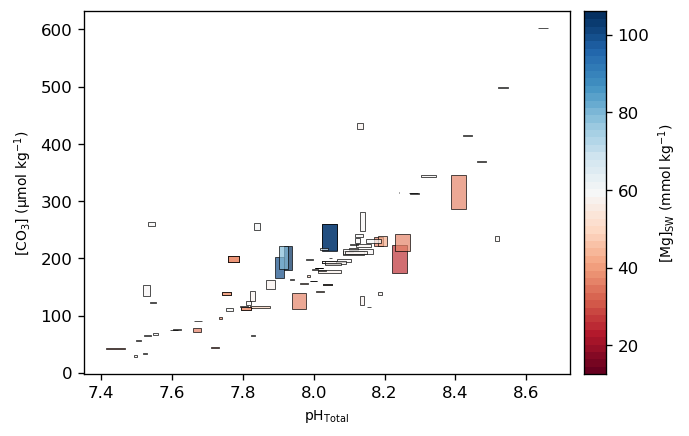

In [6]:
fig = supp_figures.C_speciation(raw)
# fig.savefig('Plots/S1_CarbonSpeciation.pdf')

In [7]:
#isolate subsets
alldat = raw.copy()

# Do not exclude any data
# idx_exclude = raw.Measured.who.isin(['Allen', 'Lea', 'Hönisch'])
idx_exclude = np.full(raw.shape[0], False)
idx_include = ~idx_exclude
dat = raw.loc[idx_include]

# isolate Russell et al (2004) data for comparison
idx_rus = raw.Measured.who == 'Russell'
rus = raw.loc[idx_rus]

# isolate data from all other studies, for later comparison
otherdat = raw.loc[idx_exclude]

Text(0, 0.5, 'Mg/Ca$_{O. universa}$')

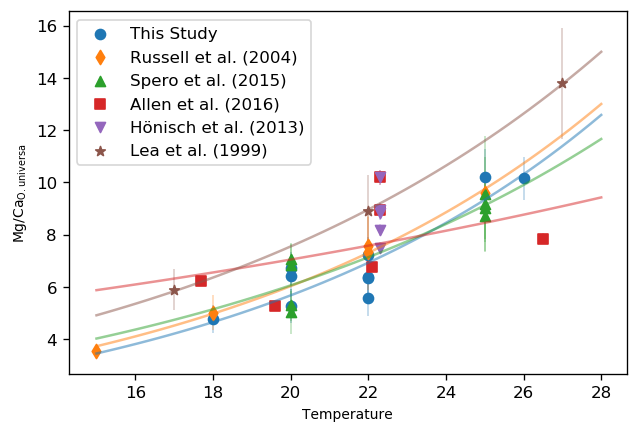

In [8]:
amb = isolate_constant_conditions(raw, DIC=2000, pH=8.1, Mg=50, Ca=10, pH_tolerance=0.2)

def expfn(x, a, b):
    return b * np.exp(x * a)

xn = np.linspace(15, 28)

fig, ax = plt.subplots()
for k, m in mdict.items():
    ind = amb.Measured.who == k
    x = amb.loc[ind, ('Measured', 'Temp')]
    y = amb.loc[ind, ('Measured', 'Mg/Caf')]
    ye = amb.loc[ind, ('Measured', 'Mg/Caf 2se')]
    
    pts = ax.scatter(x, y, marker=m, label=ldict[k])
    ax.errorbar(x, y, ye, lw=0, elinewidth=1, alpha=0.3, zorder=-3)
    
    if k == 'Hönisch':
        # don't plot line of best fit for Hönisch data - only one Temperature
        continue
    
    p, cov = curve_fit(expfn, x, y)
    
    pred = expfn(xn, *p)
    
    ax.plot(xn, pred, alpha=0.5, color=pts.get_facecolor()[0])
    
ax.legend()

ax.set_xlabel('Temperature')
ax.set_ylabel('Mg/Ca$_{O. universa}$')

#### Data observations:
- Our data, Russell et al (2004) and Spero et al (2015) are in close agreement. All these data are included in our analysis.
- Data from Lea et al (1999) are elevated, but show an approximately similar relationship. These *could* be the result of anlytical offsets, and be adjusted to match Russell et al (2004). However, as the uncertainties in Lea et al are of similar order of magnitude to the effects observed in them, we have opted not to include them.
- Data from Allen et al (2016) show a general increase with temperature, but with a drastically different slope from all previous studies. The 22C data are problematic. This treatment contains both the highest two Mg/Ca values, and has a variance that approximately equals the rest of the dataset. This indicates that there is significant variance in this data that is not attributable to any controlled variable. We therefore exclude this data from our analyses.
- Data from Hönisch et al (2013) are only available at a single temperature for ambient conditions. These data points are within the range of other data, however these analyses data derive from the same analyses as Allen et al (2016). This is evident in the two problematically high 22C points from Allen et al (2016) also being present in the Hönisch et al (2013) data set. For this reason, we exclude these data from analysis.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.2 Data Examination: Parameter Space <a id='paramspace'></a>

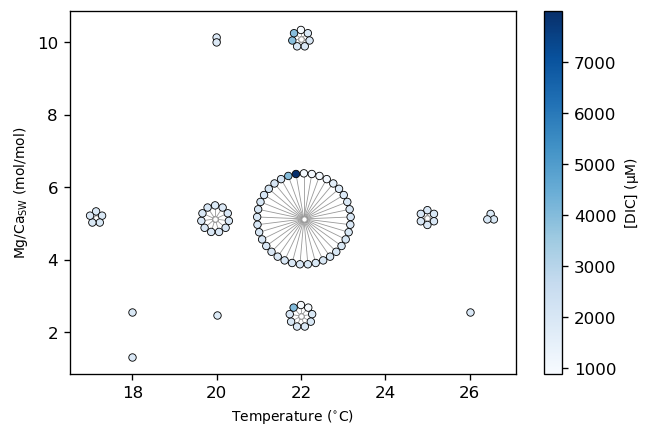

In [9]:
_ = supp_figures.parameter_space(dat)

The data cover a wide range of temperature, seawater Mg/Ca (varying both [Mg] and [Ca] independently), and [DIC]. There are also variations with pH, which will be explored later.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.3 Data Examination: Mg/Ca vs. Temperature <a id='mgca_temp'></a>

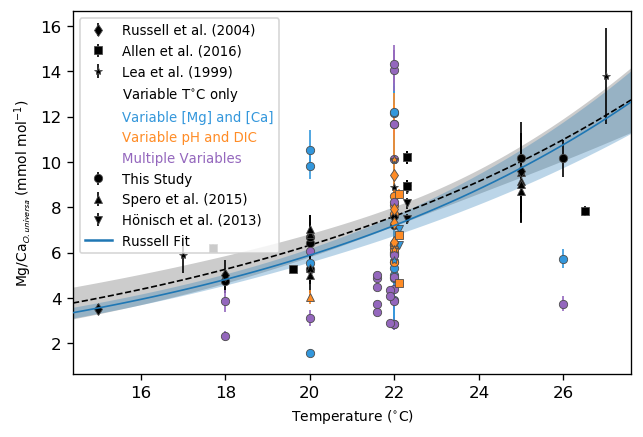

In [10]:
fig, ax = figures.fig1(dat, rus, mdict, ldict)
# fig.savefig('Plots/01_Overview.pdf')

The Mg/Ca vs. Temperature trend in our ambient cultures is similar to that observed in previous studies (Russell et al, 2004). However, substantial variance is also driven by changing [Mg], [Ca] and carbon system chemistry, both in isolation and combination.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.4 Carbon System <a id='Cchem_var'></a>

As well as exploring the influences of [Mg], [Ca] and Temperature on Mg/Ca, our culture matrix allows us to pick apart the influence of individual aspects of the carbon system, because we have independently varied pH and [CO3]:

(<Figure size 720x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8070dcff98>)

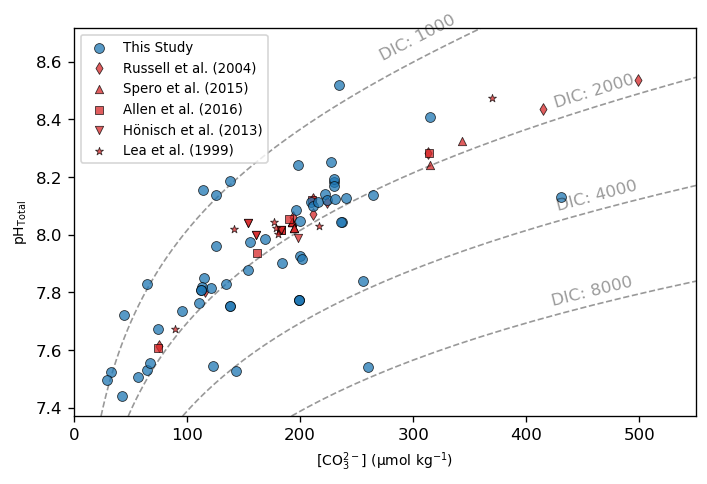

In [11]:
supp_figures.carb_chem(raw, dat, mdict, ldict)
# fig.savefig('Plots/S_pH_CO3.pdf')

All previous studies (red points) have modified pH while keeping DIC relatively constant, leading to the co-variation of pH and [CO3], making the influence of these parameters indistinguishable in the data.

Our new data (blue points) separate pH and [CO3], allowing us to separate the influence of these parameters on the data.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 1.5 Influence of [B] on pH-effects <a id='Beffects'></a>

Is it possible that elevated [B] in culture media mask pH effects by buffering seawater?

To test this, we examine Mg/Ca<sub>O. universa</sub> from our experiments where only pH and [B] vary. If [B] has an influence on the sensitivity of Mg/Ca<sub>O. universa</sub> to pH, we would expect to see systematic differences between the response of high- and low-[B] cultures to pH.

Previous studies have found Mg/Ca<sub>O. universa</sub> to be negatively correlated with pH, particularly at low pH. If elevated [B] acts to supress pH-sensitivity by buffering the local environment, we would expect to observe a reduced sensitivity to pH at high [B].

Text(0, 0.5, 'Mg/Ca ($mmol\\ mol^{-1}$)')

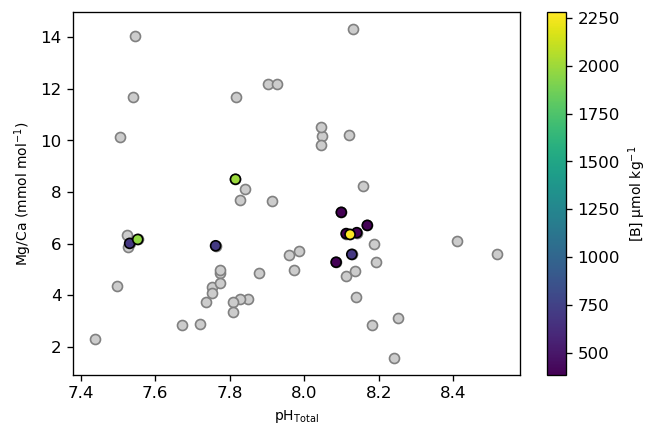

In [12]:
sub = isolate_constant_conditions(dat.loc[dat.Measured.who == 'This Study'], Temp=22, Mg=50, Ca=10, DIC=2000)

fig, ax = plt.subplots(1, 1)

ax.scatter(dat.loc[dat.Measured.who == 'This Study', ('csys_mid', 'pHtot')], 
           dat.loc[dat.Measured.who == 'This Study', ('Measured', 'Mg/Caf')], color=(.8, .8, .8), edgecolor=(.5,.5,.5))
cb = ax.scatter(sub.loc[:, ('csys_mid', 'pHtot')], sub.loc[:, ('Measured', 'Mg/Caf')], c=sub.loc[:, ('Measured', 'B umol/kg')], edgecolor='k')

fig.colorbar(cb, ax=ax, label='[B] $\mu mol\ kg^{-1}$')

ax.set_xlabel('$pH_{Total}$')
ax.set_ylabel('Mg/Ca ($mmol\ mol^{-1}$)')

# fig.savefig('Plots/S2_BoronEffects.pdf')

There are no clear systematic differences in pH-Mg/Ca<sub>O. universa</sub> patterns between high- and low-[B] treatments. At low pH, Mg/Ca is idential between [B] of ~700 and ~2000 $\mu mol\ kg^{-1}$. At ambient pH the high [B] (~2200) treatment is indistinguishable from the ambient [B] (~400) treatments. At intermediate pH (~7.8), the high [B] (~2000) treatment has elevated Mg/Ca<sub>O. universa</sub>. The Mg/Ca<sub>O. universa</sub> produced by low-[B] treatments is indistinguishable between the three pH levels, whereas the greatest differences between Mg/Ca<sub>O. universa</sub> at different pH levels is observed in the *high*-[B] treatments. If [B] were suppressing a pH effect via local buffering, we would expect this pattern to be reversed, with lower variance between pH treatments in the in the high-[B] treatments.

These patterns are consistent with [B] having an insignificant effect on Mg/Ca<sub>O. universa</sub>, and we will include these elevated [B] data in our analyses.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 2. On Uncertainties in Foraminiferal Geochemistry <a id='uncertainties'></a>


Foraminiferal geochemistry exhibits significant inter-individual variability, driven by a variety of largely unconstratined factors including intra-test heterogeneity, biological variability, individual differences in symbiont/respiration micro-environment influence... etc.

A geochemical measurement of a single foraminifera ($g$) shell will deviate from the population mean ($\mu$) a as a function of the variance resulting from inter-individual variability which, assuming it is normally distributed, can be represented as the standard deviation ($\sigma$):

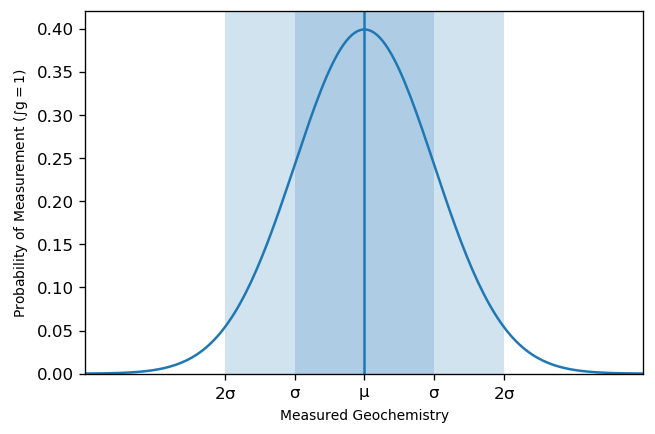

In [13]:
x = np.linspace(1, 9, 200)

pop = 5
sigma = 1

indi = stats.norm(pop, sigma)

fig, ax = plt.subplots(1, 1)
ax.plot(x, indi.pdf(x))
ax.set_xlabel('Measured Geochemistry')
ax.set_ylabel('Probability of Measurement ($\int g = 1$)')
ax.set_ylim(0, 0.42)
ax.set_xlim(1, 9)

ax.set_xticks([pop - 2 * sigma, pop - sigma, pop, pop + sigma, pop + 2 * sigma])
ax.set_xticklabels(['$2\sigma$', '$\sigma$', '$\mu$', '$\sigma$', '$2\sigma$'])

ax.axvline(pop)
ax.axvspan(pop-sigma, pop+sigma, alpha=0.2)
ax.axvspan(pop - sigma * 2, pop + sigma * 2, alpha=0.2)

95.4% of measured values will be within $2\sigma$ of the mean, and 68.3% will be within $\sigma$ of $\mu$.

Conventional analyses foraminiferal geochemistry (excluding individual foraminifera analyses) contain multiple pooled specimens, which should reliably estimate the population when $N$ is sufficiently high, based on the principles of standard error:

$$ SE = \frac{\sigma}{\sqrt{N}} $$

Text(48.995, 0.99, 'Population $\\sigma$')

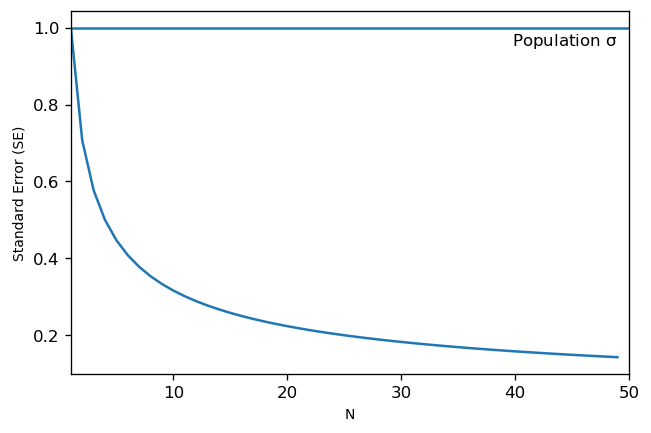

In [14]:
N = np.arange(1, 50)
se = sigma / N**0.5

fig, ax = plt.subplots(1 ,1)

ax.plot(N, se)
ax.set_ylabel('Standard Error (SE)')
ax.set_xlabel('N')
ax.set_xlim(1, 50)

ax.axhline(sigma)
ax.text(N.max() - 0.005, sigma - 0.01, 'Population $\sigma$', va='top', ha='right')

**As long as $N$ is sufficiently high**, pooled analyses offer a good estimate of the population mean.

**For cultured foraminifera, $N$ is rarely high (typically 3-20 shells), so means derived from these measurements may deviate significantly from the true population mean (i.e. SE is high).**

Our combined dataset contains a mixture of pooled solution analyses across a range of $N$, and averages calculated from multiple LA-ICPMS measurements. To compare these data in a consistent way, measurement uncertainties and sample size must be taken into account.

To complicate matters, different authors report substantively different estimates of measurement uncertainty, ranging from the 2SE of multiple LA-ICPMS analyses (directly related to the above plot), to the 'long term standard error' of the analytical technique used. This latter method does not account for $N$ in a pooled analysis, and likely substantially under-estimates uncertainty in the analyses. 

Given this difference, is it possible to meaningfully compare these data?

The simplest solution is to 'reconstruct' an estimated uncertainty for pooled solution measurements, based on knowledge of $N$, and the intra-population variability for *O. universa*.

Our LA-ICPMS data provide a straightforward way to do this, because we have individual analyses of multiple *O. universa* by LA-ICPMS, and can directly measure the intra-population variance.

In [15]:
# isolate our data
esub = dat.loc[dat.loc[:, ('Measured', 'Reference')] == 'This Study', :].Measured
esub = esub.loc[~esub.loc[:, 'what is the error reported'].str.contains('longterm')]
# where N > 10, so we're not biased by low samples size
esub = esub.loc[esub.numberforams > 10]

In [16]:
meas = esub.loc[:, 'Mg/Caf']  # measured Mg/Ca
se = esub.loc[:, 'Mg/Caf 2se'] / 2  # measured uncertainty from multiple individual foraminifera analyses
N = esub.numberforams  # number of forams in average
std = se * N**0.5  # calculate standard deviation

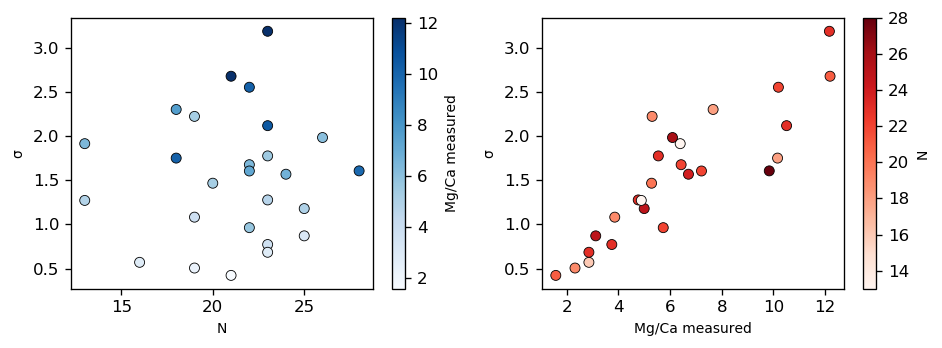

In [17]:
# plot the relationship between N, standard deviation, and Mg/Caforam

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 3])

ma = ax1.scatter(N, std, c=meas, cmap=plt.cm.Blues, lw=0.5, edgecolor='k')
fig.colorbar(ma, label='Mg/Ca measured', ax=ax1)

ax1.set_xlabel('N')
ax1.set_ylabel('$\sigma$')

ma = ax2.scatter(meas, std, c=N, cmap=plt.cm.Reds, lw=0.5, edgecolor='k')
fig.colorbar(ma, label='N', ax=ax2)

ax2.set_xlabel('Mg/Ca measured')
ax2.set_ylabel('$\sigma$')

fig.tight_layout()

We see a strong positive trend between mean Mg/Ca and $\sigma$ with an approximately zero intercept. This suggests that populations with higher Mg/Ca also exhibit more inter-individual variability.

Expressing variance as relative standard deviation ($RSD = \frac{\sigma}{\mu}$) allows us to account for this trend, and estimate a Mg/Ca-dependent population $\sigma$ for each experiment

Text(0.5, 1.0, 'Median RSD: 0.26')

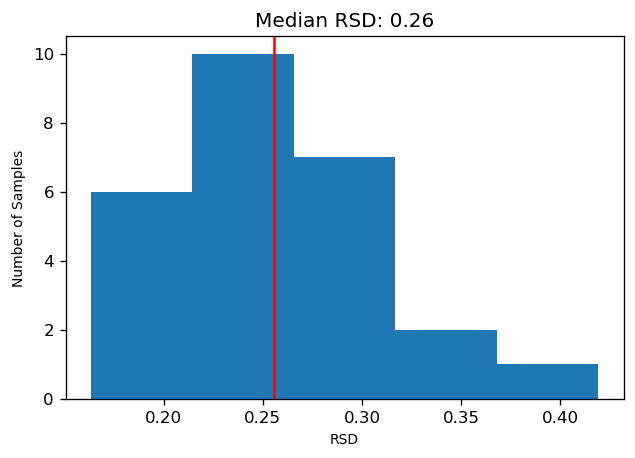

In [18]:
smeas = meas[N > 10]
sstd = std[N > 10]

# calculate rsd
srsd = sstd / smeas

plt.hist(srsd, 5)
plt.axvline(srsd.median(), c='r')

plt.xlabel('RSD')
plt.ylabel('Number of Samples')

plt.title('Median RSD: {:.2f}'.format(srsd.median()))

Population $\sigma$ is best described by an RSD of 0.26

We can use this to estimate population standard deviation from the measured Mg/Ca in all our data points, then calculate SE based on $N$.

In [19]:
ifa_rsd = srsd.median()

# calculate predicted STD and SE for all samples
raw.loc[:, ('Uncertainties', 'calc_STD')] = ifa_rsd * np.sqrt(raw.loc[:, ('Measured', 'Mg/Caf')])
raw.loc[:, ('Uncertainties', 'calc_SE')] = raw.loc[:, ('Uncertainties', 'calc_STD')] / np.sqrt(raw.loc[:, ('Measured', 'numberforams')])

# created a new 'estimated_SE' uncertainty variable from calculated SE
raw.loc[:, ('Uncertainties', 'estimated_SE')] = raw.loc[:, ('Uncertainties', 'calc_SE')]

In [20]:
ifa_rsd

0.2554548157013339

Wherever our estimated SE is greater than the reported uncertainty (e.g. for solution data), we will used the estimated value in its place.

In [21]:
# wherever estimated uncertainty is less than reported uncertainty, replace the estimated value with the reported value.
lessthanmeasured = raw.loc[:, ('Uncertainties', 'estimated_SE')] < (raw.loc[:, ('Measured', 'Mg/Caf 2se')] / 2)
raw.loc[lessthanmeasured, ('Uncertainties', 'estimated_SE')] = (raw.loc[lessthanmeasured, ('Measured', 'Mg/Caf 2se')] / 2)

Finally, we convert the estimated SE to a 95% confidence interval, which is a more conservative estimate of uncertainty.

In [22]:
# calculate 95% CI
raw.loc[:, ('Uncertainties', 'CI95')] = raw.loc[:, ('Uncertainties', 'estimated_SE')] * stats.t.interval(0.95, df=raw.loc[:, ('Measured', 'numberforams')] - 1)[-1]

In [23]:
dat = raw.loc[idx_include]
rus = raw.loc[idx_rus]
otherdat = raw.loc[idx_exclude]

In [24]:
raw.to_csv('./Data/compiled_data.csv', )

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 3. Model Formulation<a id='modelchoice'></a>

### 3.1 Individual Effects: Mg/Ca <a id='isolate_mgca'></a>

To visualise the influence of individual variables, we consider subsets of the data where each variable is constant to within +/- 10%.


In [25]:
from mg_funks.plot import angle_of_line

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


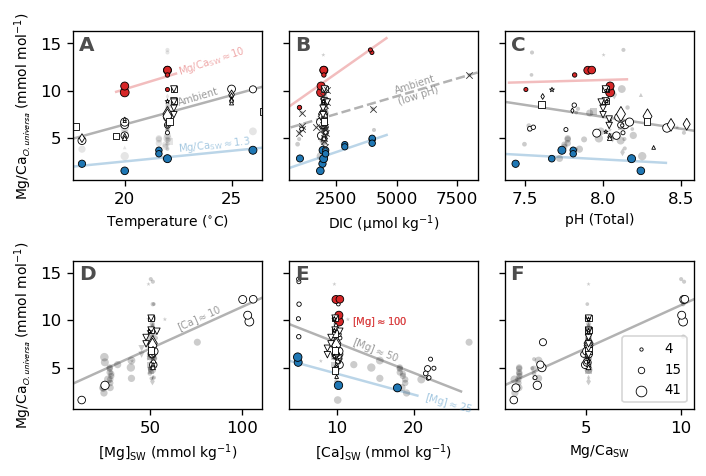

In [26]:
fig, axs = figures.fig2(dat, mdict, ldict)
    
# fig.savefig('Plots/02_isolated_parameters_MgCa.pdf')

**Observations:**
- The relationship with temperature appears linear (with a hint of the well-established exponential relationship), and is modulated by Mg/Ca<sub>SW</sub>.
- There is a linear relationship with DIC, which is modulated by Mg/Ca<sub>SW</sub>
- There is no clear relationship with pH.
- There are clear trends with [Ca], which may be the result of the corresponding modification of Mg/Ca<sub>SW</sub>.
-  [Mg] and Mg/Ca exert a dominant influence, and dwarf the other trends. The variance introduced by all other parameters is evident in the scatter of points around the linear relationships in (D) and (F). 

To remove this trend and better highlight the influence of other parameters, we'll look at this in partitioning space.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.2 Individual Effects: Partitioning <a id='isolate_part'></a>

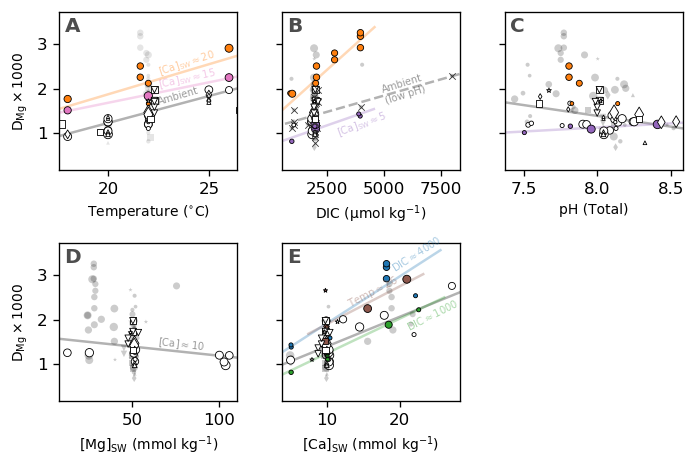

In [27]:
fig, axs = figures.fig3(dat, mdict)
# fig.savefig('Plots/03_isolated_parameters_DMg.pdf')

**Observations:**
- Temperature, DIC and [Ca]sw all influence partitioning.
- pH has no obvious *consistent* influence.
- [Mg]sw has a negligible influence on partitioning.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.3: Model Variables <a id='modelparams'></a>

Our data allow us to resolve several distinct controls on foraminiferal Mg/Ca.

First, it's clear that Mg/Ca<sub>SW</sub> exerts a primary influence on Mg/Ca<sub>foram</sub>. This is intuitive: all else being equal, we would expect calcite Mg/Ca to increase with solution Mg/Ca, as there are more opportunities for Mg to substitute for Ca. When Mg is a major impurity it interacts with crystal growth processes to alter its incorporation (Davis et al 2000, 2004), but we would expect these effects to be negligible in low-Mg hyaline foraminiferal calcite, where even 'high' Mg/Ca (~10 mmol mol<sup>-1</sup>) is below the threshold where these structural effects start to become significant. Therefore, at foraminiferal concentrations we would not expect solution Mg/Ca to significantly influence Mg partitioning. Mg/Ca<sub>SW</sub> can effectively be considered as setting the 'starting point' of foraminiferal Mg/Ca, which is then modified by other parameters that alter the Mg partitioning.

Three additional influences on Mg partitioning are evident in - Temperature, DIC, and [Ca]sw. Other carbonate system parameters (pH, CO3) have negligible effects, and while there is a slight negative relationship between [Mg]sw and partitioning, this effect is dwarfed by other parameters.

To capture the trends in our data, our model must therefore include:
- Mg/Casw
- Temperature
- [Ca]sw
- DIC

Mechanistically, it is concievable that DIC and [Ca]sw influence foraminiferal Mg/Ca by altering either aspects of ion transport, or the precipitation rate of the mineral. Temperature may exert a thermodynamic influence over Mg substitution, or alter the kinetics of Mg attachment/detachment at the precipitation surface. In reality, these are not distinct processes, and combinations of different processes likely produced the observed patterns.

- - -
Davis, K. J., Dove, P. M., & De Yoreo, J. J. (2000). The role of Mg2+ as an impurity in calcite growth. Science, 290(5494), 1134-1137.

Davis, K. J., Dove, P. M., Wasylenki, L. E., & De Yoreo, J. J. (2004). Morphological consequences of differential Mg2+ incorporation at structurally distinct steps on calcite. American Mineralogist, 89(5-6), 714-720.
- - -

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 3.4 Model Functional Form <a id='funkyform'></a>

While clear individual influences are evident in our data in the figures above, identifying a functional form that best describes these multi-dimensional relationships is not straightforward.
To avoid (conscious or unconscious) biases in our formulation of a model, we identify a functional form using a 'Model Evaluation' approach, where the ability of all possible linear models comprised of combinations and permutations of our independent variables to predict the observed data is evaluated and scored using the Bayes Factor (BF), which evaluates the relative probability of candidate models based on goodness of fit, number of samples ($N$) and model degrees of freedom.

We evaluate all combinations and permutations of the independent variabiles Temperature, Mg/Ca<sub>SW</sub>, [Mg]<sub>SW</sub>, [Ca]<sub>SW</sub>, [DIC]<sub>SW</sub> and pH<sub>SW</sub>, as well as the influence of log-transformation of all permutations of parameters.

For the full model selection method, see the [ModelSelection](link) supplement.

This comprehensive survey of candidate functional forms yielded two similarly probable funcitonal forms:
1. $ Mg/Ca_{foram} = Mg/Ca_{SW}^A\ [DIC]^B\ e^{C [Ca]_{SW} + D T + E}$ (BF<sub>best</sub> = 1)
2. $ Mg/Ca_{foram} = Mg/Ca_{SW}^A\ [DIC]^B\ T^D\ e^{C [Ca]_{SW} + E}$ (BF<sub>best</sub> = 0.805)

All other models were substanially less probable (for the next best model BF<sub>best</sub> = 0.294). Importantly, the best model which includes pH as an independent variable has a BF<sub>best</sub> = 0.138, rendering it substantially less probable than our best model. The highest BF<sub>best</sub> of all previously published Mg/Ca models is 5.2x10<sup>-10</sup>, rendering all previous models decisively less probable than our best model.

Given the well-established exponential relationship between Temperature and Mg/Ca<sub>Calcite</sub> and its basis in thermodynamic theory, we opt to use the candidate model which contains the Temperature term within the exponent. The functional that best explains the patterns in our data is therefore:

$$ Mg/Ca_{foram} = Mg/Ca_{SW}^A\ [DIC]^B\ e^{C [Ca]_{SW} + D T + E}$$

and, consequently:

$$
\begin{align}
T &= \frac{\ln\left(\frac{Mg/Ca_{foram}}{Mg/Ca_{SW}^A\ [DIC]^B}\right) - C [Ca]_{SW} - E}{D} \\
[Ca]_{SW} &= \frac{\ln\left(\frac{Mg/Ca_{foram}}{Mg/Ca_{SW}^A\ [DIC]^B}\right) - D T - E}{C} \\
[DIC]_{SW} &= \left( \frac{Mg/Ca_{foram}}{Mg/Ca_{SW}^A\ e^{C [Ca]_{SW} + D T + E}} \right)^{1/B} \\
Mg/Ca_{SW} &= \left( \frac{Mg/Ca_{foram}}{[DIC]^B\ e^{C [Ca]_{SW} + D T + E}} \right)^{1/A} \\
\end{align}
$$

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 4. Model Fitting<a id='modelfitting'></a>

In [28]:
def mgca_fn(x, A, B, C, D, E):
    """
    x = (MgCa, DIC, Ca, T)
    """
    MgCa, DIC, Ca, T = x
    return MgCa**A * DIC**B * np.exp(C * Ca + D * T + E)

def mgca_fn_u(x, A, B, C, D, E):
    """
    x = (MgCa, DIC, Ca, T)
    """
    MgCa, DIC, Ca, T = x
    return MgCa**A * DIC**B * un.unumpy.exp(C * Ca + D * T + E)

# package data for fitting
x = (dat.loc[:, ('Measured', 'Mg/Casw')],  # molar ratio (unitless)
     dat.loc[:, ('csys_mid', 'DIC')] * 1e-6,  # molar
     dat.loc[:, ('Measured', '[Ca]sw')] * 1e-3,  # molar
     dat.loc[:, ('Measured', 'Temp')])  # celcius

# weight fit as 1/N - gives more power to high sample sizes
sigma = dat.loc[:, ('Uncertainties', 'estimated_SE')]

# fit model
p, cov = curve_fit(mgca_fn, x, dat.loc[:, ('Measured', 'Mg/Caf')], 
                   sigma=sigma)

pe = un.correlated_values(p, cov)

To assess the goodness of fit of the model, we compare measured vs. predicted Mg/Ca.

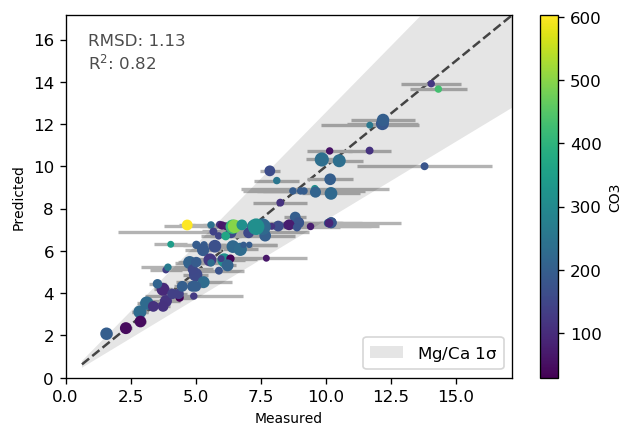

In [29]:
fig, ax = plot.compare(obs=dat.loc[:, ('Measured', 'Mg/Caf')], 
                       pred=mgca_fn(x, *p),
                       errs=dat.loc[:, ('Uncertainties', 'CI95')],
                       c=dat.loc[:, ('csys_mid', 'CO3')],
                       clab='CO3', s=2 * dat.loc[:, ('Measured', 'numberforams')])

lim = np.array(ax.get_xlim())
ax.set_xlim(0, lim[1])
ax.set_ylim(0, lim[1])
ax.fill_between(lim, lim + lim * ifa_rsd, lim - lim * ifa_rsd, alpha=0.1, color='k', lw=0, zorder=-1, label='Mg/Ca $1\sigma$')
ax.legend(loc='lower right')

And to assess whether there are any systematic patterns in the residuals (implying unaccounted for effects in the model), we plot the residual (measued - predicted) Mg/Ca as a funciton of all measured variabiles.

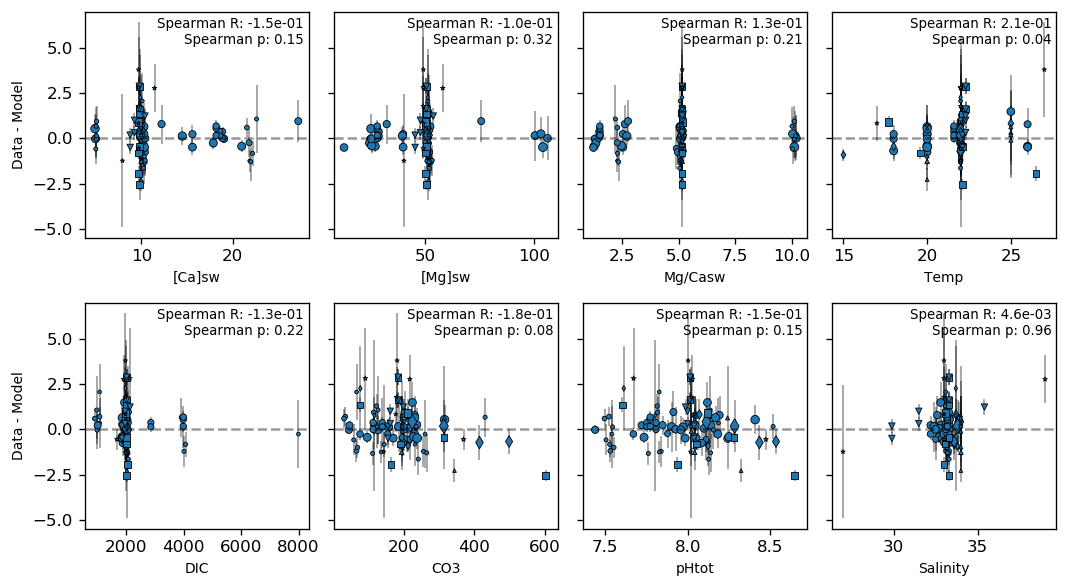

In [30]:
vari = (('Measured', '[Ca]sw'),
        ('Measured', '[Mg]sw'),
        ('Measured', 'Mg/Casw'),
        ('Measured', 'Temp'),
        ('csys_mid', 'DIC'),
        ('csys_mid', 'CO3'),
        ('csys_mid', 'pHtot'),
        ('Measured', 'Salinity'))

resid = dat.loc[:, ('Measured', 'Mg/Caf')] - mgca_fn(x, *p)
# resid_e = dat.loc[:, ('Measured', 'Mg/Caf 2se')]
resid_e = dat.loc[:, ('Uncertainties', 'CI95')]

fig, axs = plt.subplots(2, 4, figsize=(9, 5), sharey=True)

s = dat.loc[:, ('Measured', 'numberforams')]

for v, ax in zip(vari, axs.flatten()):
    
    for k, m in mdict.items():
        
        ind = dat.Measured.who == k
        
        dep = dat.loc[ind, v]
        r = resid.loc[ind]
        re = resid_e.loc[ind]
        si = s.loc[ind]
        
        ax.scatter(dep, r, zorder=2, marker=m, c='C0', edgecolor='k', lw=0.5, s=si)
        ax.errorbar(dep, r, re, lw=0, elinewidth=1, zorder=-2, c=(0,0,0,0.4))
    
    R, sp = stats.spearmanr(dat.loc[:, v], resid)
    if sp < 0.01:
        spt = '< 0.01'
    else:
        spt = '{:.2f}'.format(sp)
    stat_text = 'Spearman R: {:.1e}\nSpearman p: {}'.format(R, spt)
    ax.text(.98, .98, stat_text, va='top', ha='right', transform=ax.transAxes, fontsize=8)
    
    ax.set_xlabel(v[-1])
    if ax.is_first_col():
        ax.set_ylabel('Data - Model')
        
    ax.axhline(0, ls='dashed', color=(0,0,0,0.4))
    
fig.tight_layout()
# fig.savefig('Plots/S3_ModelResiduals.pdf')

There are no clear trends, suggesting that our model adequately captures all effects in our data.

Finally we examine data where only pH varies, so we may assess whether a minor pH effect may exist in the data that is masked by variance in the entire dataset.

This Study SpearmanrResult(correlation=0.35664335664335667, pvalue=0.25513775175895725)
Russell SpearmanrResult(correlation=-0.8571428571428573, pvalue=0.01369732661532562)
Spero SpearmanrResult(correlation=-0.7071067811865475, pvalue=0.18169011381620928)
Allen SpearmanrResult(correlation=-0.7748062179181807, pvalue=0.04076946252042033)
Hönisch SpearmanrResult(correlation=0.6324555320336759, pvalue=0.2522154963555042)
Lea SpearmanrResult(correlation=-0.9999999999999999, pvalue=nan)
all SpearmanrResult(correlation=-0.420268647246906, pvalue=0.008612426379557211)


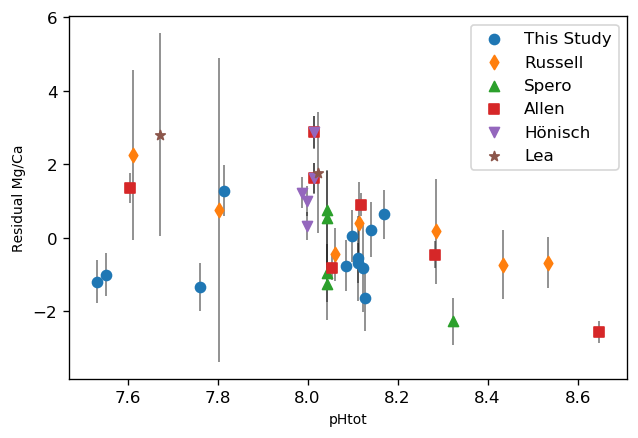

In [31]:
sub = isolate_constant_conditions(raw, Temp=20, DIC=2000, Ca=10.2, Mg=50, tolerance=0.12)

sx = (sub.loc[:, ('Measured', 'Mg/Casw')],  # molar ratio (unitless)
      sub.loc[:, ('csys_mid', 'DIC')] * 1e-6,  # molar
      sub.loc[:, ('Measured', '[Ca]sw')] * 1e-3,  # molar
      sub.loc[:, ('Measured', 'Temp')])  # celcius
r = sresid = sub.loc[:, ('Measured', 'Mg/Caf')] - mgca_fn(sx, *p)
re = sresid_e = sub.loc[:, ('Uncertainties', 'CI95')]

for k, m in mdict.items():
    ind = sub.Measured.who == k
    if any(ind):
        plt.scatter(sub.loc[ind, ('csys_mid', 'pHtot')], r[ind], marker=m, label=k)
        plt.errorbar(sub.loc[ind, ('csys_mid', 'pHtot')], r[ind], re[ind], lw=0, elinewidth=1, color=(0,0,0,0.5), zorder=-2)
        print(k, stats.spearmanr(sub.loc[ind, ('csys_mid', 'pHtot')], r[ind]))
        
print('all', stats.spearmanr(sub.loc[:, ('csys_mid', 'pHtot')], r))
    
plt.xlabel('pHtot')
plt.ylabel('Residual Mg/Ca')
plt.legend()

There is a weak but signifcant trend with pH in the residuals. This effect is most prominent in the data of Allen and Russell, and is absent in our data, Spero et al and Lea et al.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 4.2 Sanity-Check: Can the model reproduce the temperature relationship observed at ambient conditions?<a id='sanity'></a>

Text(0, 0.5, 'Mg/Ca$_{\\it{O. universa}}$ (mmol mol$^{-1}$)')

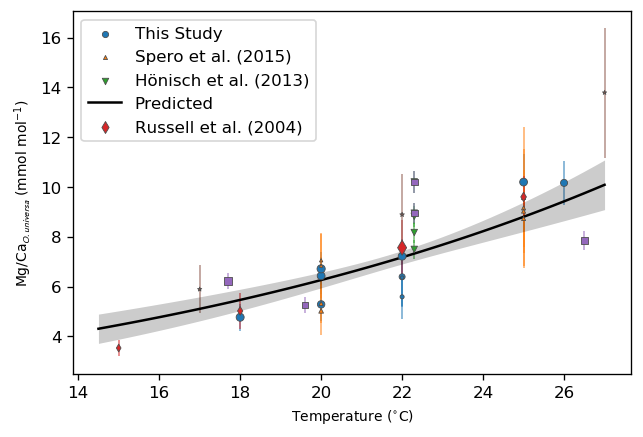

In [32]:
rsub = isolate_constant_conditions(dat, pH=8.05, DIC=2000, Mg=50, Ca=10)

for who in rsub.Measured.who.unique():
    ind = rsub.Measured.who == who
    plt.scatter(rsub.loc[ind, ('Measured', 'Temp')], rsub.loc[ind, ('Measured', 'Mg/Caf')], 
                label=ldict[who], marker=mdict[who], s=rsub.loc[ind, ('Measured', 'numberforams')], edgecolor=(.3,.3,.3), lw=0.5)
    plt.errorbar(rsub.loc[ind, ('Measured', 'Temp')], rsub.loc[ind, ('Measured', 'Mg/Caf')], 
                 rsub.loc[ind, ('Uncertainties', 'CI95')], lw=0, alpha=0.6, elinewidth=1, label='_', zorder=-2)

# package data for prediction
tn = np.linspace(14.5, 27, 50)
rx = (5.16,  # molar ratio (unitless)
      rsub.loc[:, ('csys_mid', 'DIC')].mean() * 1e-6,  # molar
      rsub.loc[:, ('Measured', '[Ca]sw')].mean() * 1e-3,  # molar
      tn)  # celcius

pred = mgca_fn_u(rx, *pe)
plt.plot(tn, nom(pred), label='Predicted', c='k', zorder=-1)
# sd = ifa_rsd * pred
sd = err(pred) * 1.96
plt.fill_between(tn, nom(pred)-sd, nom(pred)+sd, color='k', alpha=0.2, label='Model 95% CI', zorder=-1, lw=0)

plt.ylim(2.5, plt.gca().get_ylim()[1])

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,0,4]
plt.legend([handles[o] for o in order], [labels[o] for o in order])

plt.xlabel('Temperature ($^{\circ}$C)')
plt.ylabel('Mg/Ca$_{\it{O. universa}}$ (mmol mol$^{-1}$)')

# plt.savefig('Plots/05_PredictedAmbient.pdf')

Yes! Our model predicts all observed Mg/Ca data well at ambient conditions.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 5. Model Comparison<a id='modelcompare'></a> 

Our model functional form is the best of all possible linear combinations of our controlled variables, and takes the form:
$$ Mg/Ca_{foram} = [Mg/Ca_{SW}]^A\ B\ e^{(C_1\ [Ca]_{SW}\ + C_2\ [DIC]_{SW} + D)\ T} $$

To demonstrate the skill of this model, we compare it statistically and graphically to all other previously proposed models:
1) The 'traditional' exponential relationship.
$$ Mg/Ca_{foram} = B\ e^{A\ T}$$
2) Evans and Mueller (2012) power-law formulation.
$$ Mg/Ca_{foram} = \frac{Mg/Ca_{SW}^{t=t}\ ^H}{Mg/Ca_{SW}^{t=0}\ ^H} B\ e^{A\ T}$$
3) Evans et al (2015) polynomial formulation
$$ Mg/Ca_{foram} = \frac{C\ Mg/Ca_{SW}^{t=t}\ ^2 + D\ Mg/Ca_{SW}^{t=t}}{C\ Mg/Ca_{SW}^{t=0}\ ^2 + D\ Mg/Ca_{SW}^{t=0}} B\ e^{A\ T}$$
4) Gray & Evans (2019) multi-variate equation
$$ Mg/Ca_{foram} = e^{A(S - 35) + B T + C (pH - 8) + D} $$
5) Gray & Evans (2019) multi-variate equation, with modification for Mg/Ca<sup>SW</sup>
$$ Mg/Ca_{foram} = Mg/Ca_{SW}^E\ e^{A(S - 35) + B T + C (pH - 8) + D} $$


In [33]:
# model formulations

def exponential(temp, A, B):
    return A * np.exp(temp * B)

def evans2012(x, A, B, H):
    temp, mgca_t = x
    mgca_0 = 5.17
    return B * (mgca_t**H / mgca_0**H) * np.exp(A * temp)
                
def evans2015(x, A, B, C, D):
    temp, mgca_t = x
    mgca_0 = 5.17
    return B * np.exp(A * temp) * (C * mgca_t**2 + D * mgca_t) / (C * mgca_0**2 + D * mgca_0)

def gray2019(x, E, A, B, C, D):
    temp, sal, pH, mgca_t = x
    return mgca_t**E * np.exp(A * (sal - 35) + B * temp + C * (pH - 8) + D)

def gray2019_noMgCa(x, A, B, C, D):
    temp, sal, pH, mgca_t = x
    return np.exp(A * (sal - 35) + B * temp + C * (pH - 8) + D)

# set up calculation of goodness-of-fit statistics
fnforms = ['Exponential',
           'Evans & Müller (2012)',
           'Evans et al. (2015)',
           'Gray & Evans (2019)',
           'Gray & Evans (2019, with Mg/Ca)',
           'Our Model']

from scipy.stats import normaltest, ttest_1samp
from brutefit.bayesfactor import BayesFactor0

GOF = pd.DataFrame(index=fnforms, columns=['df', 'RSS', 'p_resid_norm', 'p_resid_zero','R2','AIC','BIC','BF0'])

def calc_gof(obs, pred, k):
    res = pred - obs
    
    res_norm = normaltest(res)
    res_zero = ttest_1samp(res, 0)
    
    SSres = np.sum((res)**2)
    SStot = np.sum((obs - np.mean(obs))**2)
    N = len(pred)
    R2 = 1 - SSres / SStot
    
    L = SSres / N  # likelihood
    if res_zero.pvalue > 0.05 and res_norm.pvalue > 0.05:
        # only calculate AIC and BIC if residuals are normal and zero 
        AICc = -2 * np.log(L) + 2 * k + (2 * k**2 + 2 * k) / (N - k - 1) 
        BIC = -2 * np.log(L) + 2 * np.log(N) * k
    else:
        AICc = np.nan
        BIC = np.nan
    
    BF0 = BayesFactor0(N, k, R2)
    
    return k, SSres, res_norm.pvalue, res_zero.pvalue, R2, AICc, BIC, BF0

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [34]:
preds = {}
# fit different models
sigma = dat.loc[:, ('Uncertainties', 'estimated_SE')]
y = dat.loc[:, ('Measured', 'Mg/Caf')]
# exponential
k = fnforms[0]
exp_p, _ = curve_fit(exponential, xdata=dat.loc[:, ('Measured', 'Temp')], ydata=y, sigma=sigma)
preds[k] = exponential(dat.loc[:, ('Measured', 'Temp')], *exp_p)
GOF.loc[k, :] = calc_gof(dat.loc[:, ('Measured', 'Mg/Caf')], preds[k], len(exp_p))

# Evans 2012
k = fnforms[1]
e2012_p, _ = curve_fit(evans2012, xdata=(dat.loc[:, ('Measured', 'Temp')], dat.loc[:, ('Measured', 'Mg/Casw')]),
                       ydata=y, sigma=sigma)
preds[k] = evans2012((dat.loc[:, ('Measured', 'Temp')], dat.loc[:, ('Measured', 'Mg/Casw')]), *e2012_p)
GOF.loc[k, :] = calc_gof(dat.loc[:, ('Measured', 'Mg/Caf')], preds[k], len(e2012_p))

# Evans 2015
k = fnforms[2]
e2015_p, _ = curve_fit(evans2015, xdata=(dat.loc[:, ('Measured', 'Temp')], dat.loc[:, ('Measured', 'Mg/Casw')]),
                       ydata=y, sigma=sigma)
preds[k] = evans2015((dat.loc[:, ('Measured', 'Temp')], dat.loc[:, ('Measured', 'Mg/Casw')]), *e2015_p)
GOF.loc[k, :] = calc_gof(dat.loc[:, ('Measured', 'Mg/Caf')], preds[k], len(e2015_p))


# Gray 2019 with Mg/Ca
k = 'Gray & Evans (2019, with Mg/Ca)'
gx = (dat.loc[:, ('Measured', 'Temp')], 
      dat.loc[:, ('Measured', 'Salinity')],
      dat.loc[:, ('csys_mid', 'pHtot')],
      dat.loc[:, ('Measured', 'Mg/Casw')])
g2019_p, _ = curve_fit(gray2019, xdata=gx, ydata=y, sigma=sigma)
preds[k] = gray2019(gx, *g2019_p)
GOF.loc[k, :] = calc_gof(dat.loc[:, ('Measured', 'Mg/Caf')], preds[k], len(g2019_p))

# Gray 2019 without Mg/Ca
k = 'Gray & Evans (2019)'
gnm2019_p, _ = curve_fit(gray2019_noMgCa, xdata=gx, ydata=y, sigma=sigma)
preds[k] = gray2019_noMgCa(gx, *gnm2019_p)
GOF.loc[k, :] = calc_gof(dat.loc[:, ('Measured', 'Mg/Caf')], preds[k], len(gnm2019_p))

# Our model
preds['Our Model'] = mgca_fn(x, *p)
GOF.loc['Our Model', :] = calc_gof(dat.loc[:, ('Measured', 'Mg/Caf')], preds['Our Model'], len(p))

GOF.loc[:, 'BF_best'] = GOF.loc[:, 'BF0'] / GOF.loc[:, 'BF0'].max()

In [35]:
GOF

,df,RSS,p_resid_norm,p_resid_zero,R2,AIC,BIC,BF0,BF_best
Exponential,2,821.09,0.0412468,4.11886e-08,-0.177949,NaN,NaN,0.000140418,9.10935e-34
Evans & Müller (2012),3,187.752,0.0360175,0.0427501,0.730648,NaN,NaN,9.44828e+22,6.12939e-07
Evans et al. (2015),4,216.889,0.235884,0.0534528,0.688848,6.80949,34.8847,1.91956e+19,1.24528e-10
Gray & Evans (2019),4,807.763,0.0158161,1.12252e-07,-0.15883,NaN,NaN,6.67153e-05,4.32803e-34
"Gray & Evans (2019, with Mg/Ca)",5,156.906,0.122933,0.066824,0.7749,9.68407,44.6609,3.79753e+24,2.46358e-05
Our Model,5,123.181,0.0193124,0.116825,0.823283,NaN,NaN,1.54147e+29,1


Our model is the only models with normally distributed, zero-centered residuals. 
All other models violate the assumptions behind the calculation of AIC or BIC, so it is not possible to use these to evaluate models.
Instead, we may gauge the relative quality of these models by three key criteria:
1. Goodness-of-Fit: Our model produces both the highest R<sup>2</sup> and Residual Sum of Squares (RSS) values, indicating that it does a good job predicting the observed variance in the data.
2. Residual (model - data) normality and location: No other model produces residuals that are normally distributed and centered around zero. This is strong evidence that our model predicts all observed variance in the data. Conversely, the non-normality and non-zero residuals produced by all other models constitutes strong evidence that they do not account for a systematic effect in the data.
3. Bayes Factors. The Bayes Factor relative to a null model (BF0) may be calculated from R<sup>2</sup>, sample size and number of covariates to give an estimate of relative model quality, while avoiding assumptions regarding the normality and position of the residuals. From this, we can calculate Bayes Factor relative to the best model (BF_best) which provides a measure of the relative probabilities of the models.

Together, these metrics provide strong evidence that our model provides the best available description of the data.

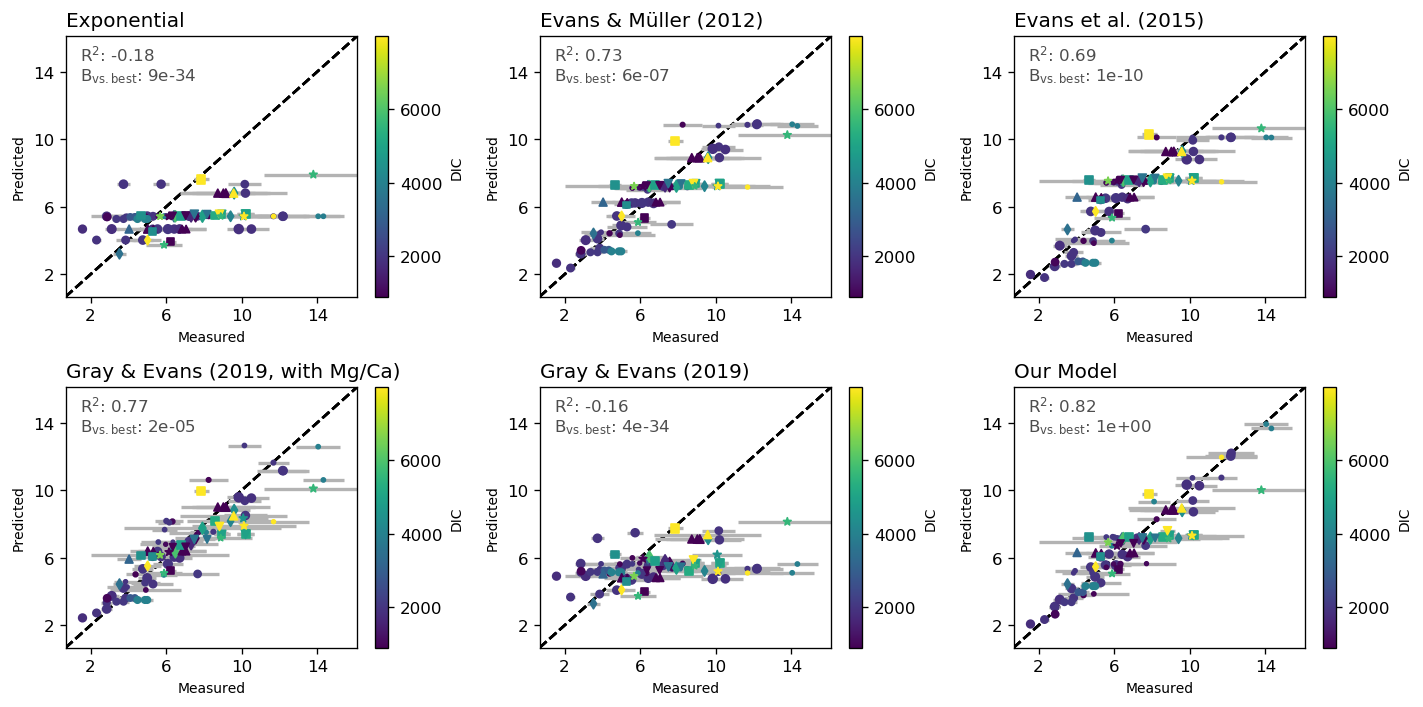

In [36]:
fig, axs = plt.subplots(2, 3, figsize=[12, 6])

# cvar = ('Measured', '[Ca]sw')
cvar = ('csys_mid', 'DIC')

for ax, (label, pred) in zip(axs.flat, preds.items()):
    ax.set_title(label, loc='left')
    cbar = True
    for who, m in mdict.items():
        ind = dat.Measured.who == who
        if sum(ind) == 0:
            continue
        plot.compare(obs=dat.loc[ind, ('Measured', 'Mg/Caf')], 
                     pred=pred[ind],
                     errs=dat.loc[ind, ('Uncertainties', 'CI95')],
                     c=dat.loc[ind, cvar], clab=cvar[-1], cbar=cbar, show_stats=False,
                     figax=(fig, ax), s=dat.loc[:, ('Measured', 'numberforams')],
                     marker=m, vmin=dat.loc[ind, cvar].min(), vmax=dat.loc[ind, cvar].max())
        cbar = False
    ax.set_xticks(np.arange(2, 17, 4))
    ax.set_yticks(np.arange(2, 17, 4))
    ax.text(.05, 0.97, '$R^2$: {:.2f}\n'.format(GOF.loc[label, 'R2']) + '$B_{vs. best}$: ' + '{:.0e}'.format(GOF.loc[label, 'BF_best']), 
            transform=ax.transAxes, va='top', ha='left', color=(.3,.3,.3))
fig.tight_layout()

# fig.savefig('Plots/S4_model_comparison.pdf')
# fig.savefig('Plots/S4_model_comparison.png')

(0, 0.39962164773799425)

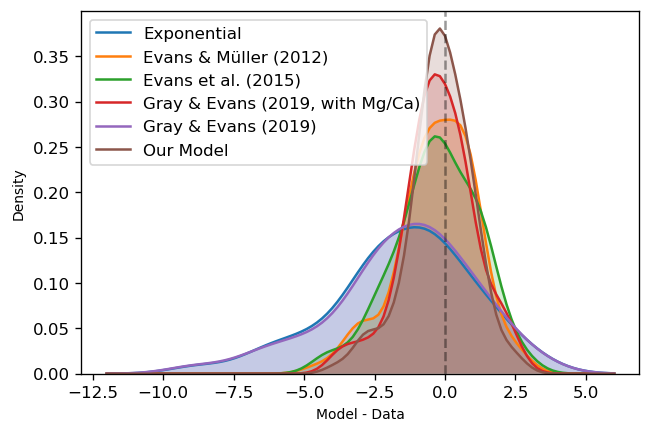

In [37]:
# view distributions of residuals

fig, ax = plt.subplots(1, 1)
bins = np.linspace(-12, 6, 100)
for label, pred in preds.items():
    kde = stats.gaussian_kde(pred - y)
    pdf = kde.evaluate(bins)
    ax.fill_between(bins, pdf, alpha=0.2)
    ax.plot(bins, pdf, label=label)
    
ax.axvline(0, ls='dashed', c=(0,0,0,0.4))
ax.legend()
ax.set_xlabel('Model - Data')
ax.set_ylabel('Density')
ax.set_ylim(0, ax.get_ylim()[1])

Final, differences in model skill can be compared using a Taylor diagram.

In [38]:
preds.update({0: dat.loc[:, ('Measured', 'Mg/Caf')] * 1e3})

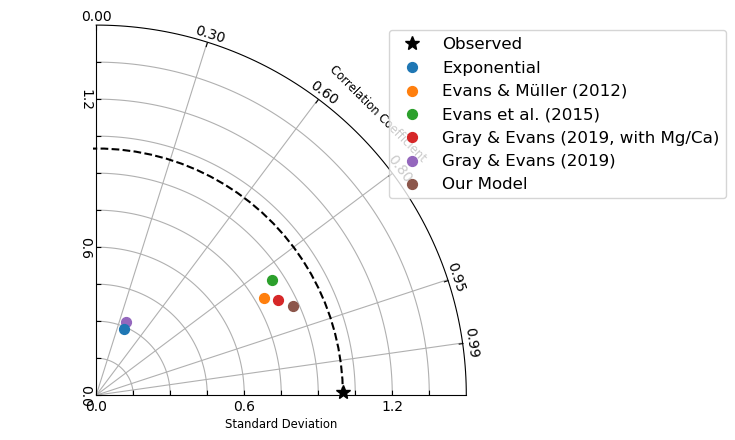

In [39]:
tpreds = preds.copy()
tpreds[0] = dat.loc[:, ('Measured', 'Mg/Caf')]

fig, ax = taylor_diag.Taylor_diag(tpreds)

All models which include Mg/Ca<sub>SW</sub> offer significant improvements over those that do not. Our model offers a substantial improvement over previous models by including the influence of DIC and [Ca].

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 6. Model Fit Uncertainties<a id='mc_uncertainties'></a>

For convenience, our model fits have been weighted by 1/N to account for sample size. We now explore the effects of measurement uncertainties by Monte-Carlo error resampling.

In [40]:
# resample parameters within uncertainties
rerun = False

if not os.path.exists('Data/MonteCarloOutput.npy') or rerun:
    np.random.seed(42)  # set random state, for reproducibility
    N = 10000

    # initialise random variables
    MgCasw = np.random.normal(dat.loc[:, ('Measured', 'Mg/Casw')], 0.1, (N, dat.shape[0]))
    DICsw = np.random.uniform(dat.loc[:, ('pitzer', 'DIC')] * 1e-6, dat.loc[:, ('MyAMI', 'DIC')] * 1e-6, (N, dat.shape[0]))
    Casw = np.random.normal(dat.loc[:, ('Measured', '[Ca]sw')] * 1e-3, 0.1e-3, (N, dat.shape[0]))
    Temp = np.random.normal(dat.loc[:, ('Measured', 'Temp')], 0.1, (N, dat.shape[0]))

    MgCaforam = np.random.normal(dat.loc[:, ('Measured', 'Mg/Caf')], dat.loc[:, ('Uncertainties', 'CI95')], (N, dat.shape[0]))

    p_opt = np.zeros((N, 5))

    for i in tqdm(range(N)):
        p, cov = curve_fit(mgca_fn, (MgCasw[i], DICsw[i], Casw[i], Temp[i]), MgCaforam[i])
        p_opt[i] = p

    np.save('Data/MonteCarloOutput_allData', p_opt)
else:
    p_opt = np.load('Data/MonteCarloOutput_allData.npy')

In [41]:
# calculate corrlation matrix
mc_cor = np.corrcoef(p_opt.T)

# calculate covariance matrix
mc_cov = np.cov(p_opt.T)

View parameter distributions and interactions

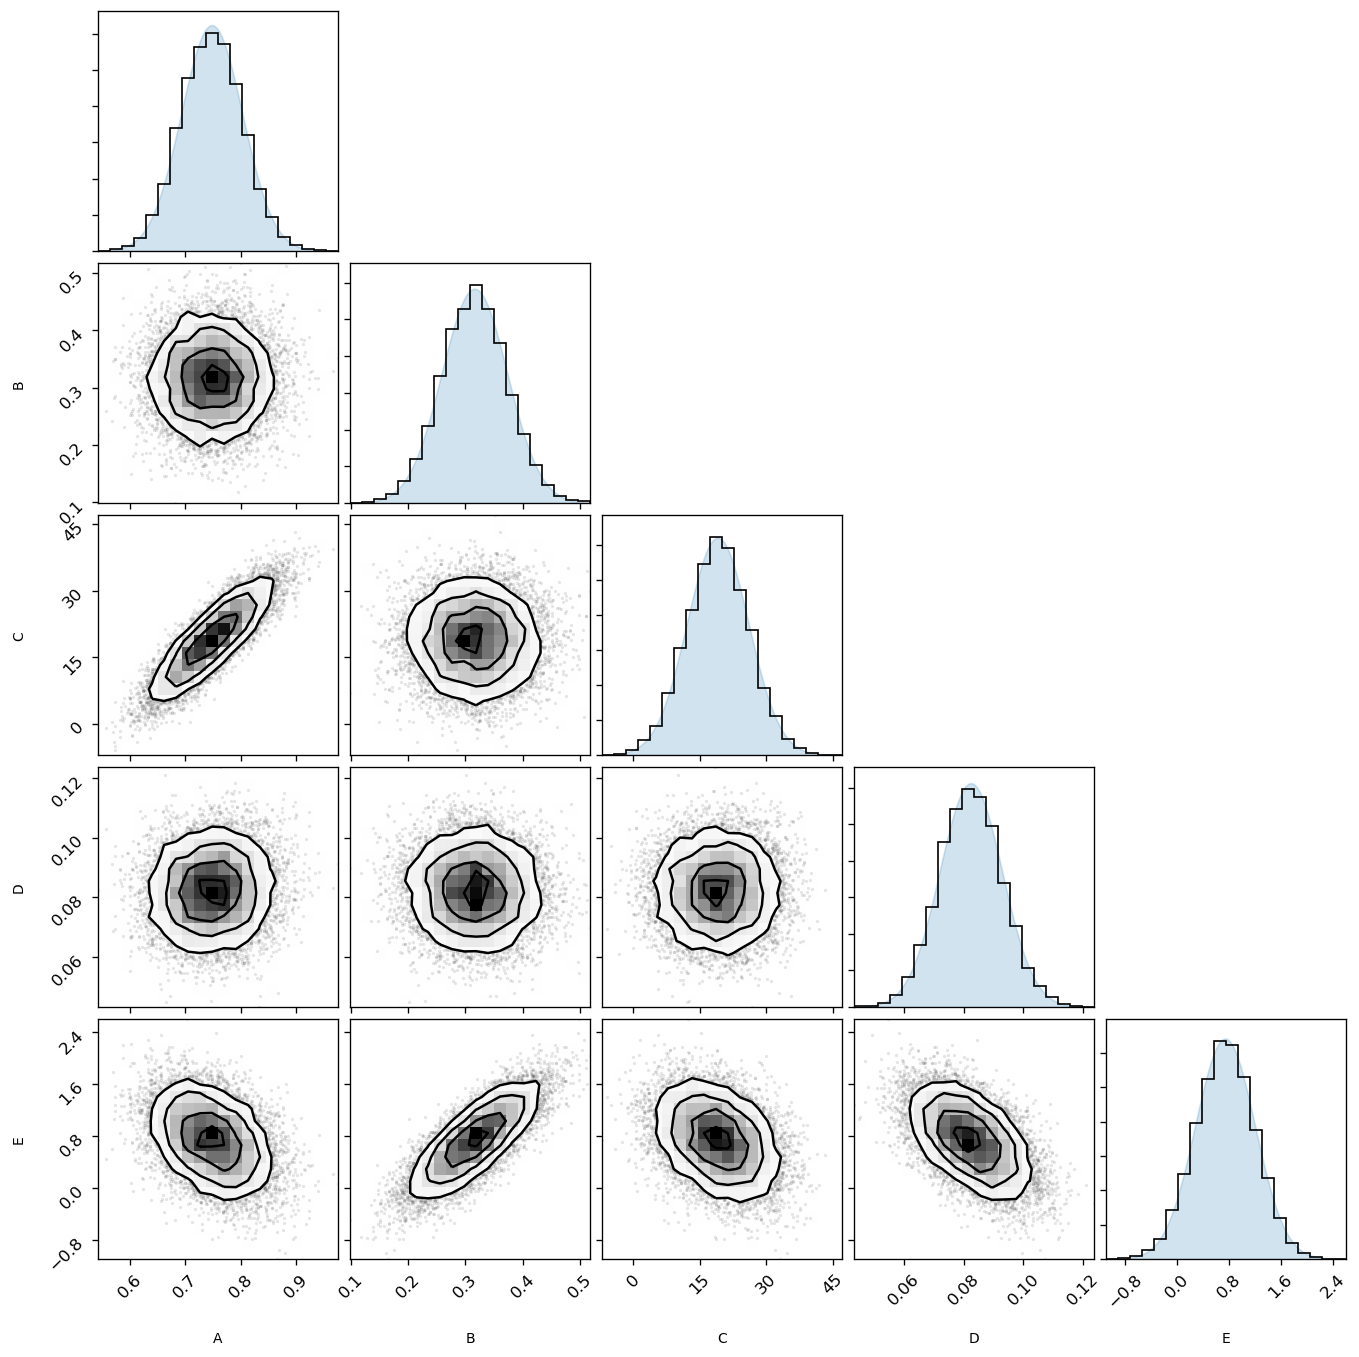

In [42]:
# mc_dist = stats.multivariate_normal(p_opt.mean(0), mc_cov)
means = p_opt.mean(0)
scales = np.sqrt(np.diag(mc_cov))

fig = corner.corner(p_opt, labels=['A', 'B', 'C', 'D', 'E'])

axs = np.array(fig.get_axes()).reshape(mc_cov.shape)
n = 100
for i in range(5):
    ax = axs[i,i]
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x = np.linspace(*xlim, n)
    y = stats.norm.pdf(x, means[i], scales[i]) * (10000 * np.diff(xlim) / 20)
    ax.fill_between(x, y, zorder=-1, color='C0', alpha=0.2)

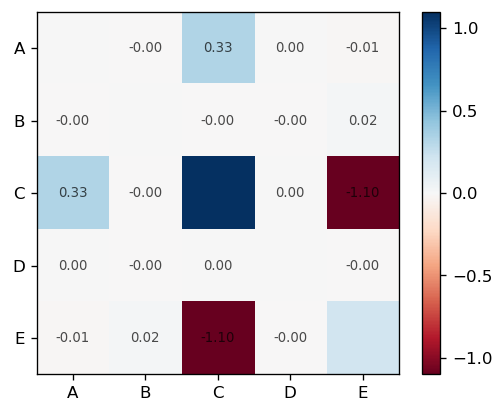

In [43]:
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

mat = mc_cov

# draw image
ma = ax.imshow(mat, cmap=plt.cm.RdBu, vmax=1.1, vmin=-1.1)

# write on correlation values
for i, j in zip(*np.triu_indices(mat.shape[0])):
    if i != j:
        c = mat[i, j]
        ax.text(i, j, '{:.2f}'.format(c), va='center', ha='center', alpha=0.7, fontsize=8)
        ax.text(j, i, '{:.2f}'.format(c), va='center', ha='center', alpha=0.7, fontsize=8)

ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
labs = ['A', 'B', 'C', 'D', 'E']
ax.set_xticklabels(labs)
ax.set_yticklabels(labs)

cb = fig.colorbar(ma)
cb.set_ticks(np.linspace(-1, 1, 5))

There ia strong covariance between some of the parameters - most notably between A and C, and C and E. This is not necessarily a problem, as the system is over-determined. However, it is instructive to consider the source of this covariance:
- A & C: Covariance in A (Mg/Ca<sub>SW</sub>) and C ([Ca]<sub>SW</sub>) is intuitive, as [Ca] is included in both terms.
- C & E: It is less clear why the influence of [Ca]<sub>SW</sub> should correlate with the constant offset term E.

**Importantly, these correlations must be accounted for in uncertainty propagation.**
Not accounting for these correlations will dramatically over-estimate uncertainties.

In [44]:
# package Monte Carlo parameter values and covariance matrix
params = un.correlated_values(p_opt.mean(0), mc_cov)

print(("Optimised Parameters\n" +
      "   A: {:.3f}\n".format(params[0]) +
      "   B: {:.3f}\n".format(params[1]) +
      "   C: {:.3f}\n".format(params[2]) +
      "   D: {:.3f}\n".format(params[3]) +
      "   E: {:.3f}\n".format(params[4])))

Optimised Parameters
   A: 0.748+/-0.056
   B: 0.316+/-0.057
   C: 19.039+/-6.962
   D: 0.082+/-0.010
   E: 0.739+/-0.461



Although note parameter covariance should be taken into account when propagating these uncertainties.

In [45]:
# predict data using Monte Carlo parameters
x = (dat.loc[:, ('Measured', 'Mg/Casw')],  # molar ratio (unitless)
     dat.loc[:, ('csys_mid', 'DIC')] * 1e-6,  # molar
     dat.loc[:, ('Measured', '[Ca]sw')] * 1e-3,  # molar
     dat.loc[:, ('Measured', 'Temp')])  # celcius

obs = dat.loc[:, ('Measured', 'Mg/Caf')]
obs_err = dat.loc[:, ('Uncertainties', 'CI95')]

pred = mgca_fn_u(x, *params)

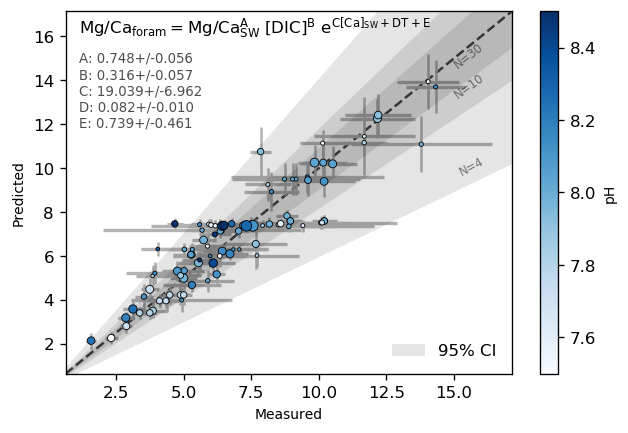

In [46]:
ind = np.ones(dat.shape[0], dtype=bool)

fig, ax = plot.compare(obs=dat.loc[ind, ('Measured', 'Mg/Caf')], 
                       pred=nom(pred[ind]),
                       errs=dat.loc[ind, ('Uncertainties', 'CI95')],
                       c=dat.loc[ind, ('csys_mid', 'pHtot')],
                       clab='pH', cmap=plt.cm.Blues, lw=0.5, edgecolor='k',
                       s=dat.loc[ind, ('Measured', 'numberforams')], vmin=7.5, vmax=8.5, show_stats=False)

ax.errorbar(obs[ind], nom(pred[ind]), 
            yerr=1.96 * err(pred[ind]), lw=0, elinewidth=1.5, capsize=0, c=(.7,.7,.7), zorder=-1)

label1 = '$Mg/Ca_{foram} = Mg/Ca_{SW}^A\ [DIC]^B\ e^{C [Ca]_{SW} + D T + E}$\n'

label2 = ("A: {:.3f}\n".format(params[0]) +
          "B: {:.3f}\n".format(params[1]) +
          "C: {:.3f}\n".format(params[2]) +
          "D: {:.3f}\n".format(params[3]) +
          "E: {:.3f}\n".format(params[4]))

ax.text(.03, .99, label1, ha='left', va='top', transform = ax.transAxes, fontsize=10)
ax.text(.03, .89, label2, ha='left', va='top', transform = ax.transAxes, fontsize=8, color=(.3,.3,.3))

lim = np.array(ax.get_xlim())
for n in [4, 10, 30]:
    i = stats.t.interval(0.95, df=n-1)[-1]
    if n == 4:
        lab = '95% CI'
    else:
        lab = '_'
    ax.fill_between(lim, 
                    lim + i * (lim * ifa_rsd) / n**0.5, 
                    lim - i * (lim * ifa_rsd) / n**0.5, 
                    alpha=0.1, color='k', lw=0, zorder=-1, label=lab)

ax.text(16.2, 9.7, 'N=4',  ha='right', rotation=28, fontsize=7, alpha=0.5)
ax.text(16.2, 13.2, 'N=10', ha='right', rotation=36, fontsize=7, alpha=0.5)
ax.text(16.2, 14.6, 'N=30', ha='right', rotation=38, fontsize=7, alpha=0.5)

ax.legend(loc='lower right', framealpha=0)

A model vs. data plot using the Monte-Carlo calculated uncertainties. Shaded bars represent measurement 95% confidence intervals for foraminiferal Mg/Ca measurements, given different Mg/Ca concentrations and sample sizes.

#### Predict Temperature

$$ T = \frac{\ln\left(\frac{Mg/Ca_{foram}}{Mg/Ca_{SW}^A\ [DIC]^B}\right) - C [Ca]_{SW} - E}{D} $$

In [47]:
# prediction function
def T_fn(x, A, B, C, D, E):
    """
    x = (MgCaf, MgCasw, DIC, Ca)
    """
    MgCaf, MgCasw, DIC, Ca = x
    return (np.log(MgCaf / (MgCasw**A * DIC**B)) - Ca * C - E) / D

def T_fn_u(x, A, B, C, D, E):
    """
    x = (MgCaf, MgCasw, DIC, Ca)
    """
    MgCaf, MgCasw, DIC, Ca = x
    return (un.unumpy.log(MgCaf / (MgCasw**A * DIC**B)) - Ca * C - E) / D

# package data for fitting
xt = (dat.loc[:, ('Measured', 'Mg/Caf')],  # mmol $mol^{-1}$
      dat.loc[:, ('Measured', 'Mg/Casw')],  # molar ratio (unitless)
      dat.loc[:, ('csys_mid', 'DIC')] * 1e-6,  # molar
      dat.loc[:, ('Measured', '[Ca]sw')] * 1e-3)  # molar

In [48]:
pred_T = T_fn_u(xt, *params)

# calculate predicted T error arising from foram variability at modern conditions
mgca_s = np.linspace(2, 15)
dic = 2000e-6
ca = 10.2e-3
mgcasw = 5.1

med_ifa = nom(T_fn_u((mgca_s, mgcasw, dic, ca), *params))

cis_lower = []
cis_upper = []

for n in [4, 10, 30]:
    m = ifa_rsd * stats.t.interval(0.95, df=n-1)[-1] / n**0.5
    cis_upper.append(nom(T_fn_u((mgca_s + mgca_s * m, mgcasw, dic, ca), *params)))
    cis_lower.append(nom(T_fn_u((mgca_s - mgca_s * m, mgcasw, dic, ca), *params)))

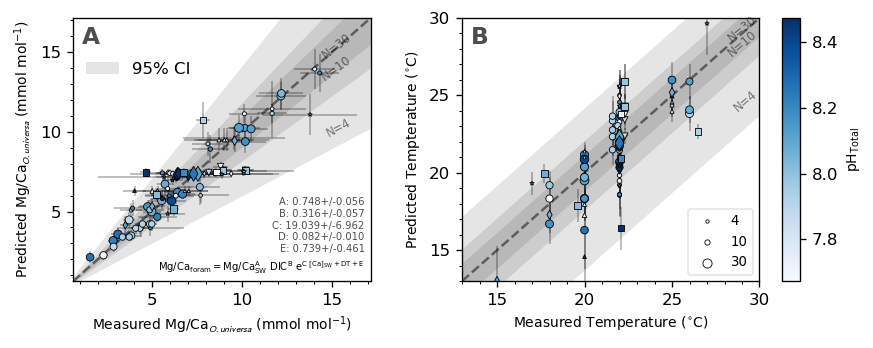

In [49]:
fig, ax = figures.fig4(dat, params, pred, pred_T, ifa_rsd, mdict, cis_upper, cis_lower, med_ifa)

# fig.savefig('Plots/04_model_comparison.pdf')
# fig.savefig('Plots/04_model_comparison.png')

This plot shows measured vs. predicted temperature. There is considerable scatter around the 1:1 line, but this scatter is within the 1 standard deviation error envelope for individual analyses - we would expect considerable scatter around this line, given the small N in many of our samples.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 7. Mg/Ca Sensitivity Analysis<a id='sensitivity'></a>

In [50]:
from mg_funks.plot import lbl_position_checker, panel_coord, gradpanel

## 7.0 Individual Effects

With an optimised model, we may now examine the individual influences of each independent variable.

To do this, we use the model to subtract the influence of all but one varriable from the data, allowing us to view the insidivual effect of that variable in the entire dataset when all other parameters are constant.

We show everything relevant to a 'standard' condition where Mg/Ca = 5.17, [Ca] = 10.2 mM, DIC = 2 mM and T = 22.

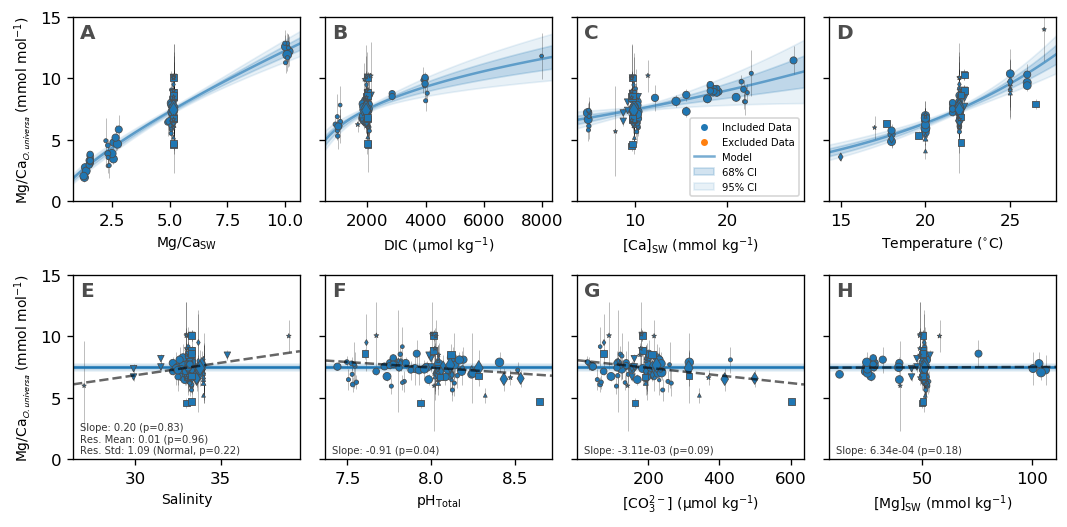

In [51]:
standard_x = [5.17, 2000e-6, 10.2e-3, 22]

fig = figures.fig6(raw, mgca_fn_u, params, idx_exclude, mdict, standard_x)
# fig.savefig('Plots/06_Individual_Effects.pdf')

The individual effects of Mg/Ca, Ca, DIC and T and their funcitonal forms are showin the top panel of the figure.

Using the same method, we may also explore possibly tertiary influences on Mg/Ca that are not included in the model.
The lower row of panels in this figure demonstrate that parameters not included in the model exert no influence on the data.

### Change from Main Supplement:
The negative trend in hte residuals with pH is weakly significant when the model is fitted to *all* the data.

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 7.1 Modification of palaeothermometer sensitivity <a id='sens_indiv'></a>

The 'sensitivity' of the Mg/Ca palaeothermometer can be considered as proportional to the instantaneous slope of the Mg/Ca - Temperature relationship - i.e. the change in Mg/Ca observed per unit temperature change. Given the form:
$$
y = A e^{Bx}
$$
The sensitivity is:
$$
\frac{\delta y}{\delta x} = A B e^{B x}
$$
From this, it is evident that the palaeothermometer sensitivity (slope of the relationship) depends upon both the pre-exponential and exponential terms of the equation.

Here, we explore the influence of the additional non-temperature terms in our model on the Mg/Ca-Temperature relationship.

$$
\begin{align}
T &= \frac{\ln\left(\frac{Mg/Ca_{foram}}{Mg/Ca_{SW}^A\ [DIC]^B}\right) - C [Ca]_{SW} - E}{D} \\
[Ca]_{SW} &= \frac{\ln\left(\frac{Mg/Ca_{foram}}{Mg/Ca_{SW}^A\ [DIC]^B}\right) - D T - E}{C} \\
[DIC]_{SW} &= \left( \frac{Mg/Ca_{foram}}{Mg/Ca_{SW}^A\ e^{C [Ca]_{SW} + D T + E}} \right)^{1/B} \\
Mg/Ca_{SW} &= \left( \frac{Mg/Ca_{foram}}{[DIC]^B\ e^{C [Ca]_{SW} + D T + E}} \right)^{1/A} \\
\end{align}
$$

In [52]:
def DIC_fn(x, A, B, C, D, E):
    """
    x = (MgCasw, Casw, MgCaf, Temp)
    """
    MgCasw, Casw, MgCaf, Temp = x
    return (MgCaf / (MgCasw**A * np.exp(C * Casw + D * Temp + E)))**(1/B)

def DIC_fn_u(x, A, B, C, D, E):
    """
    x = (MgCasw, Casw, MgCaf, Temp)
    """
    MgCasw, Casw, MgCaf, Temp = x
    return (MgCaf / (MgCasw**A * un.unumpy.exp(C * Casw + D * Temp + E)))**(1/B)


def MgCasw_fn(x, A, B, C, D, E):
    """
    x = (Casw, DICsw, MgCaf, Temp)
    """
    Casw, DICsw, MgCaf, Temp = x    
    return (MgCaf / (DICsw**B * np.exp(C * Casw + D * Temp + E)))**(1/A)

def MgCasw_fn_u(x, A, B, C, D, E):
    """
    x = (Casw, DICsw, MgCaf, Temp)
    """
    Casw, DICsw, MgCaf, Temp = x    
    return (MgCaf / (DICsw**B * un.unumpy.exp(C * Casw + D * Temp + E)))**(1/A)


def Ca_fn(x, A, B, C, D, E):
    """
    x = (MgCasw, DICsw, MgCaf, Temp)
    """
    MgCasw, DICsw, MgCaf, Temp = x
    return (np.log(MgCaf / (MgCasw**A * DICsw**B)) - Temp * D - E) / C

def Ca_fn_u(x, A, B, C, D, E):
    """
    x = (MgCasw, DICsw, MgCaf, Temp)
    """
    MgCasw, DICsw, MgCaf, Temp = x
    return (un.unumpy.log(MgCaf / (MgCasw**A * DICsw**B)) - Temp * D - E) / C

In [53]:
nom_params = nom(params)
MgCasw, DICsw, Casw, Temp = standard_x

iT = np.linspace(15, 30, 500)
iMgCaf = np.linspace(3, 13, 500)

T, MgCaf = np.meshgrid(iT, iMgCaf)

pDIC = DIC_fn((MgCasw, Casw, MgCaf, T), *nom_params).astype(float)
pCa = Ca_fn((MgCasw, DICsw, MgCaf, T), *nom_params).astype(float)
pMgCasw = MgCasw_fn((Casw, DICsw, MgCaf, T), *nom_params).astype(float)

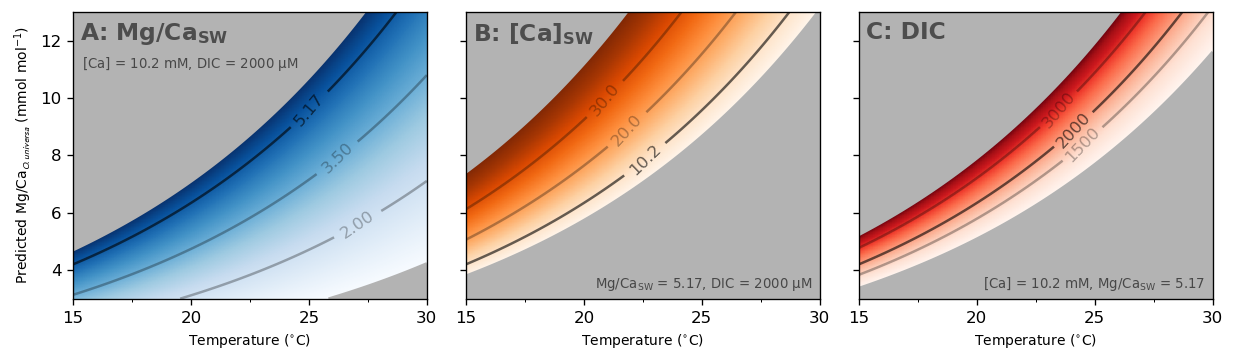

In [54]:
cm = plt.cm.Blues_r
cm.set_bad(  (.8,.8,.8, 0))
cm.set_under((.8,.8,.8, 0))
cm.set_over( (.8,.8,.8, 0))

w = 88 / 25.4
size = (w * 3, w * .9)

fig, (MgCasw_axs, Casw_axs, DIC_axs) = plt.subplots(1, 3, sharey=True, figsize=size)

axs = MgCasw_axs, Casw_axs, DIC_axs


# Mg/CaSW plot
cmb = plt.cm.Blues
cmb.set_over((.7, .7, .7))
cmb.set_under((.7, .7, .7))

ma = MgCasw_axs.pcolormesh(T, MgCaf, pMgCasw, cmap=cmb, vmin=1, vmax=6)
cs = MgCasw_axs.contour(T, MgCaf, pMgCasw, [2, 3.5, 5.17], colors=[(0,0,0,0.3),(0,0,0,0.3), (0,0,0,0.6)])
MgCasw_axs.contour(T, MgCaf, pMgCasw, [1, 6], colors=[(.7,.7,.7)])
plot.contour_labels(cs, MgCasw_axs, fmt='%0.2f', hshift=.4, vshift=.2)


MgCasw_axs.text(.025, .85, '[Ca] = {:.1f} mM, DIC = {:.0f} $\mu$M'.format(Casw*1e3, DICsw*1e6), va='top', ha='left', 
                transform=MgCasw_axs.transAxes, color=(0,0,0,0.6), fontsize=8)

# Ca plot
cmo = plt.cm.Oranges
cmo.set_over((.7, .7, .7))
cmo.set_under((.7, .7, .7))

Casw_axs.pcolormesh(T, MgCaf, pCa, cmap=cmo, vmin=5e-3, vmax=40e-3)
cs = Casw_axs.contour(T, MgCaf, pCa * 1e3, [10.2, 20, 30], colors=[(0,0,0,0.6),(0,0,0,0.3),(0,0,0,0.3)])
Casw_axs.contour(T, MgCaf, pCa * 1e3, [5, 40], colors=[(.7,.7,.7)])
plot.contour_labels(cs, Casw_axs, fmt='%0.1f')

Casw_axs.text(0.98, 0.02, 'Mg/Ca$_{SW}$ ' + '= {:.2f}, DIC = {:.0f} $\mu$M'.format(MgCasw, DICsw*1e6), va='bottom', ha='right', 
                transform=Casw_axs.transAxes, color=(0,0,0,0.6), fontsize=8)

# DIC plot
cmr = plt.cm.Reds
cmr.set_over((.7, .7, .7))
cmr.set_under((.7, .7, .7))

DIC_axs.pcolormesh(T, MgCaf, pDIC, cmap=cmr, vmin=1000e-6, vmax=4000e-6)
cs = DIC_axs.contour(T, MgCaf, pDIC * 1e6, [1500, 2000, 3000], colors=[(0,0,0,0.3),(0,0,0,0.6),(0,0,0,0.3)])
DIC_axs.contour(T, MgCaf, pDIC * 1e6, [1000, 4000], colors=[(.7,.7,.7)])
plot.contour_labels(cs, DIC_axs, fmt='%0.0f', hshift=.3)

DIC_axs.text(0.98, 0.02, '[Ca] = {:.1f} mM, '.format(Casw*1e3) + 'Mg/Ca$_{SW}$ ' + '= {:.2f}'.format(MgCasw), va='bottom', ha='right', 
                transform=DIC_axs.transAxes, color=(0,0,0,0.6), fontsize=8)

MgCasw_axs.set_ylabel("$Predicted\ Mg/Ca_{\it{O. universa}}\ (mmol\ mol^{-1})$")

for ax, lab in zip(axs, ['A: $Mg/Ca_{SW}$', 'B: $[Ca]_{SW}$', 'C: DIC']):
    ax.set_xlabel('$Temperature\ (^{\circ}C)$')
    ax.text(.02, .97, lab, ha='left', va='top', transform=ax.transAxes, 
            weight="bold", fontsize=14, color=(.3, .3, .3), zorder=2)
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2.5))

fig.tight_layout()

# fig.savefig('Plots/08_Sensitivity.png', dpi=600)

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 7.2 Relative Sensitivities <a id='sens_rel'></a>

How sensitive is Mg/Ca to parameters other than temperature?

To assess this, we calculate the change in Mg/Ca<sub>*O. universa*</sub> that would result from a temperature elevation from 22 to 23 C at ambient conditions. We then determine how much [Ca], Mg/Ca<sub>SW</sub> or DIC would have to change to produce a similar change in Mg/Ca<sub>*O. universa*</sub>

In [55]:
from scipy import optimize as opt

In [56]:
MgCasw, DICsw, Casw, Temp = standard_x

T_delta = mgca_fn((MgCasw, DICsw, Casw, 23.), *nom_params) - mgca_fn(standard_x, *nom_params)

def Casw_delta(del_Casw, T_delta):
    delta = mgca_fn((MgCasw, DICsw, Casw + del_Casw, Temp), *nom_params) - mgca_fn(standard_x, *nom_params)
    return (delta - T_delta)**2

def DICsw_delta(del_DICsw, T_delta):
    delta = mgca_fn((MgCasw, DICsw + del_DICsw, Casw, Temp), *nom_params) - mgca_fn(standard_x, *nom_params)
    return (delta - T_delta)**2

def MgCasw_delta(del_MgCasw, T_delta):
    delta = mgca_fn((MgCasw + del_MgCasw, DICsw, Casw, Temp), *nom_params) - mgca_fn(standard_x, *nom_params)
    return (delta - T_delta)**2

In [57]:
MgCa_22 = mgca_fn_u(standard_x, *params)

In [58]:
mgca_fn_u((MgCasw, DICsw, Casw, 23.), *params), MgCa_22

(8.114956094873373+/-0.17969202731050948,
 7.472959269332772+/-0.1327117926788992)

In [59]:
Ca_delta = opt.minimize(Casw_delta, 0, args=(T_delta))
DIC_delta = opt.minimize(DICsw_delta, 0, args=(T_delta))
MgCa_delta = opt.minimize(MgCasw_delta, 0, args=(T_delta))

In [60]:
# Mg/Ca change resulting from 1C temperature increase from 22->23C at ambient conditions
T_delta, (T_delta / MgCa_22) * 100

(0.6419968255406001, 8.59093168318474+/-0.15256579132394976)

In [61]:
# mmol kg [Ca] change (assuming constant Mg/Ca) required to cause the same change in foram Mg/Ca
Ca_delta.x * 1e3, Ca_delta.x / Casw

(array([4.32894603]), array([0.42440647]))

In [62]:
# umol kg Ca change required to cause the same change in foram Mg/Ca
DIC_delta.x * 1e6, DIC_delta.x / DICsw

(array([596.15577409]), array([0.29807789]))

In [63]:
# Mg/Ca change required to cause the same change in foram Mg/Ca
MgCa_delta.x, MgCa_delta.x / MgCasw

(array([0.60261009]), array([0.11655901]))

In [64]:
# mmol kg [Mg] change (assuming constant Ca) required to cause the same change in foram Mg/Ca
((5 + MgCa_delta.x) * 10.2) - (5. * 10.2)

array([6.14662291])

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 7.3 Propagation of Uncertainties to T reconstructions. <a id='unc_prop'></a>

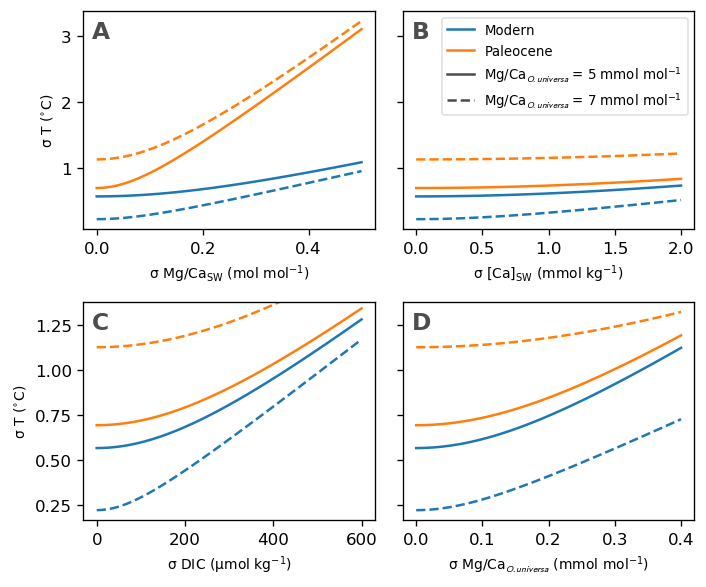

In [65]:
fig, axs = figures.fig8(params)

# fig.savefig('Plots/10_Uncertainty_Propagation.pdf')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 7.4 Past Seawater Conditions <a id='past_sw'></a>

In [66]:
idx = pd.IndexSlice

psw = pd.read_excel('Data/Past_SW.xlsx', header=(0, 1), index=None)
psw.reset_index(drop=True, inplace=True)
psw.sort_index(1, inplace=True)

r = psw.loc[0,idx[:,('Max','Min')]]

#### Smooth Mg/Ca record using Gaussian-weigted moving average

In [67]:
xn = np.linspace(0, 120, 500)

# sort values by age
apsw = psw.sort_values(('Age (Myr)', 'Mean'))

In [68]:
# isolate Mg/Ca data
dmgca = apsw.loc[~np.isnan(apsw.loc[:, ('Mg/Casw (mol/mol)', 'Mean')]),
                 idx[('Age (Myr)', 'Mg/Casw (mol/mol)', 'Reference'), ('Mean','Reference')]]

xr_mgca = dmgca.loc[:, ('Age (Myr)', 'Mean')].values
yr_mgca = dmgca.loc[:, ('Mg/Casw (mol/mol)', 'Mean')].values
ref_mg = dmgca.loc[:, ('Reference', 'Reference')].values

In [69]:
# Mg/Ca Smoothing
yn_mgca = weighted_moving_average(xr_mgca, yr_mgca, xn, 15)

# PETM Mg/Ca
weighted_moving_average(xr_mgca, yr_mgca, np.array([56.]), 15)

{'mean': array([2.09521976]),
 'std': array([0.33347463]),
 'stderr': array([0.07860073])}

#### Approximate Ca trend as linear

In [70]:
# isolate Ca data
dca = apsw.loc[~np.isnan(apsw.loc[:, ('Casw (mM)', 'Mean')]),
               idx[('Age (Myr)', 'Casw (mM)', 'Reference'), ('Mean', 'Min', 'Max','Reference')]]

# Ca Smoothing
xr_ca = dca.loc[:, ('Age (Myr)', 'Mean')].values
yr_ca = dca.loc[:, ('Casw (mM)', 'Mean')].values
ref_ca = dca.loc[:, ('Reference', 'Reference')].values

# with uncertainties.
xr_ca_e = np.concatenate([dca.loc[:, ('Age (Myr)', 'Mean')].values,
                   dca.loc[:, ('Age (Myr)', 'Min')].values,
                   dca.loc[:, ('Age (Myr)', 'Max')].values])  # add min & max values to incorporate uncertainties
yr_ca_e = np.concatenate([dca.loc[:, ('Casw (mM)', 'Mean')].values,
                        dca.loc[:, ('Casw (mM)', 'Min')].values,
                        dca.loc[:, ('Casw (mM)', 'Max')].values])
# ref_ca_e = np.concatenate([dca.loc[:, ('Reference', 'Reference')].values] * 3)

# exclude data > 120kr
yr_ca = yr_ca[xr_ca < 120]
ref_ca = ref_ca[xr_ca < 120]
xr_ca = xr_ca[xr_ca < 120]

yr_ca_e = yr_ca_e[xr_ca_e < 120]
# ref_ca_e = ref_ca[xr_ca < 120]
xr_ca_e = xr_ca_e[xr_ca_e < 120]

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [71]:
import matplotlib as mpl

In [72]:
# estimate Ca
lin = lambda x, m, c: x * m + c

p, cov = curve_fit(lin, xr_ca_e, yr_ca_e)
ca_p = un.correlated_values(p, cov)
yn_ca = lin(xn, *ca_p)


In [73]:
time = xn
T = np.linspace(15, 30, 500).reshape((500, 1))
mgcasw = yn_mgca['mean']
casw = nom(yn_ca) * 1e-3
dic = 2000e-6
mx, my = np.meshgrid(time, T)

# MgCa, Ca, C, T
MgCa_CC = mgca_fn((mgcasw, dic, casw, T), *nom(params)) 

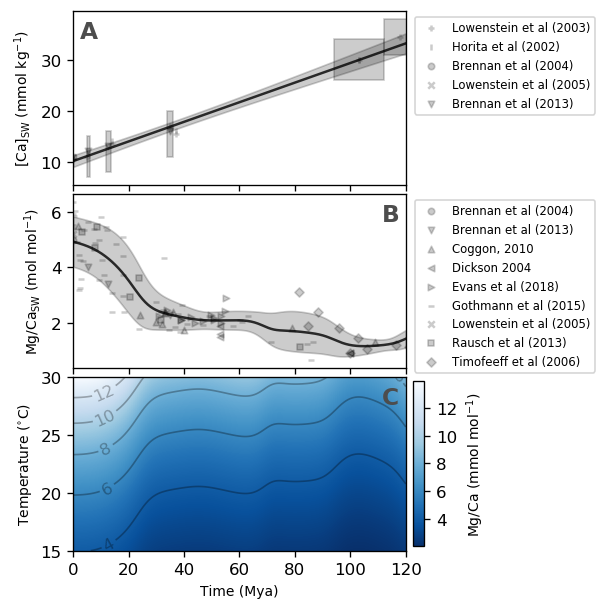

In [74]:
fig = figures.fig9(xn, yn_ca, yn_mgca, ref_ca, ref_mg, yr_mgca, xr_mgca, MgCa_CC, mx, my, dca)
    
# fig.savefig('Plots/09_Past_SW_Sensitivity.png', dpi=600)

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

## 8. PETM Application<a id='PETM'></a>

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 8.1 Adapt our calibration to multi-species data from Anand et al (2003) <a id='multi_species'></a>

In [75]:
ad = pd.read_csv('Data/Anand_recalculated.csv', comment='#', converters={'d18Ow': un.ufloat_fromstr,
                                                                         'Ctemp': un.ufloat_fromstr,
                                                                         'sal': un.ufloat_fromstr})

# Exclude Aequilateralis and Orbulina, after Anand et al (2003).
ad = ad.loc[[s not in ['G. aequilateralis', 'O. universa', 'O. universa (thick test)'] for s in ad.Species]]
# ad = ad.loc[[s not in ['G. aequilateralis'] for s in ad.Species]]

ad.loc[:, 'nom_Ctemp'] = nom(ad.loc[:, 'Ctemp'])

# Remove missing data
ad.dropna(subset=['nom_Ctemp', 'Mg/Ca (mmol/mol)'], inplace=True)

In [76]:
# ad

In [77]:
def exponent_MgCa(T, A, B):
    if isinstance(A, un.core.AffineScalarFunc) or isinstance(B, un.core.AffineScalarFunc):
        exp = un.unumpy.exp
    else:
        exp = np.exp
    
    return A * exp(B * T)

def exponent_temp(MgCa, A, B):
    if isinstance(A, un.core.AffineScalarFunc) or isinstance(B, un.core.AffineScalarFunc):
        log = un.unumpy.log
    else:
        log = np.log

    return log(MgCa / A) / B

ap, acov = curve_fit(exponent_MgCa, nom(ad.loc[:, 'Ctemp']), ad.loc[:, 'Mg/Ca (mmol/mol)'])

exp_anand_params = un.correlated_values(ap, acov)

#### Adjust our model so that it fits the multi-species data of Anand et al. 

Initially, we did this by fitting terms to modify both the offset (<b>E</b>) and temperature sensitivity (<b>D</b>) terms in our model. However, the optimal <b>D</b> modifier was not significantly different from 1, so was not necessary.

In [78]:
def make_anand_fit(params):
    def fit_fn(x, mE):
        MgCa, DIC, Ca, T = x
        A, B, C, D, E = nom(params)
        return MgCa**A * DIC**B * np.exp(C * Ca + D * T + E + mE)

    
    def fit_fn_u(x, mE):
        MgCa, DIC, Ca, T = x
        A, B, C, D, E = params
        return MgCa**A * DIC**B * un.unumpy.exp(C * Ca + D * T + E + mE)

    return fit_fn, fit_fn_u

anand_fit, anand_fit_u = make_anand_fit(params)

# package data for fitting
x = ([standard_x[0]] * ad.shape[0],  # Mg/Ca molar ratio (unitless)
     [standard_x[1]] * ad.shape[0],  # [DIC] molar
     [standard_x[2]] * ad.shape[0],  # [Ca], molar
     nom(ad.loc[:, 'Ctemp']))  # celcius

# fit model
p, cov = curve_fit(anand_fit, x, ad.loc[:, 'Mg/Ca (mmol/mol)'])

# pack parameter and uncertainty
mE = un.ufloat(p, cov[0])

# combine with original parameters to make anand-modified parameters set
aparams = (*params[:-1], params[-1] + mE)

Text(0, 0.5, 'Mg/Ca (mmol $mol^{-1}$)')

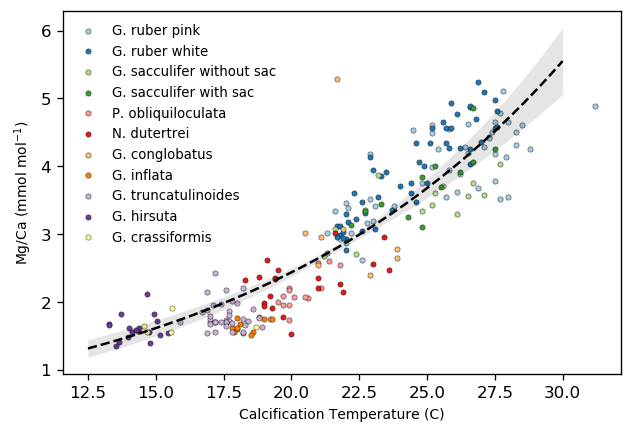

In [79]:
sdict = dict(zip(ad.Species.unique(), np.arange(ad.Species.unique().size) / ad.Species.unique().size))

fig, ax = plt.subplots(1, 1)

for s in ad.Species.unique():    
    ind = ad.Species == s
    ax.scatter(nom(ad.loc[ind, 'Ctemp']),
               nom(ad.loc[ind, 'Mg/Ca (mmol/mol)']),
               label=s, s=10, color=plt.cm.Paired(sdict[s]), lw=0.4, edgecolor=(0,0,0,0.6))

# calculate best fit line
tnew = np.linspace(12.5, 30, 50)
fit = mgca_fn_u((*standard_x[:-1], tnew), *aparams)

ax.plot(tnew, nom(fit), c='k', ls='dashed')
ax.fill_between(tnew,
                nom(fit) - err(fit),
                nom(fit) + err(fit),
                color=(0,0,0,0.1), lw=0)

ax.legend(loc='upper left', fontsize=8, framealpha=0)

ax.set_xlabel('Calcification Temperature (C)')
ax.set_ylabel('Mg/Ca (mmol $mol^{-1}$)')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 8.2 Apply Calibration to PETM Record <a id='PETM_app'></a>

In [80]:
petm = pd.read_csv('Data/Penman_2014_PETM.csv')

xnew = np.linspace(petm.loc[:, 'Time rel. PETM onset'].min(),
                   petm.loc[:, 'Time rel. PETM onset'].max(), 100)
time = np.linspace(petm.loc[:, 'Age_ma'].min(),
                   petm.loc[:, 'Age_ma'].max(), 100)

petm_MgCa = weighted_moving_average(xr_mgca, yr_mgca, time, 15)
petm_MgCa = un.unumpy.uarray(petm_MgCa['mean'], petm_MgCa['std'])

petm_Ca = time * ca_p[0] + ca_p[1]

# calculate gaussian-weighted moving weigted average of Mg/Ca across PETM
petm_mgca = weighted_moving_average(petm.loc[:, 'Time rel. PETM onset'], 
                                    petm.loc[:, 'Mg/Ca_mmol'],
                                    xnew, 30)

petm_mgca_eprop = un.unumpy.uarray(petm_mgca['mean'], petm_mgca['std'])

In [81]:
# load DIC datas
petm_DIC_LOSCAR = pd.read_csv('Data/DIC_Zeebe_2009.csv', comment='#').sort_values('Time_WRT_CIE')
petm_DIC_Gutjahr = pd.read_csv('Data/DIC_Gutjahr_2017.csv', comment='#').sort_values('Time_WRT_CIE')
petm_DIC_Haynes = pd.read_csv('Data/DIC_Haynes_2017.csv', comment='#').sort_values('Time_WRT_CIE')

# interpolate DIC for Temp calculation
interp_petm_DIC_LOSCAR = weighted_moving_average(petm_DIC_LOSCAR.Time_WRT_CIE, petm_DIC_LOSCAR.DIC, xnew, 15)
interp_petm_DIC_LOSCAR = un.unumpy.uarray(interp_petm_DIC_LOSCAR['mean'], interp_petm_DIC_LOSCAR['std'])

interp_petm_DIC_Gutjahr = weighted_moving_average(petm_DIC_Gutjahr.Time_WRT_CIE, petm_DIC_Gutjahr.DIC, xnew, 15)
interp_petm_DIC_Gutjahr = un.unumpy.uarray(interp_petm_DIC_Gutjahr['mean'], interp_petm_DIC_Gutjahr['std'])

interp_petm_DIC_Haynes = weighted_moving_average(petm_DIC_Haynes.Time_WRT_CIE, petm_DIC_Haynes.DIC, xnew, 15)
interp_petm_DIC_Haynes = un.unumpy.uarray(interp_petm_DIC_Haynes['mean'], interp_petm_DIC_Haynes['std'])

/home/oscar/GitHub/ForamGeochem/Supplementary/Holland_MgCa/mg_funks/helpers.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(sum((x > xn - 2 * sigma) & (x < xn + 2 * sigma)))


In [82]:
def evans2012_temp(MgCa, MgCa_t, A, B, H):
    if isinstance(A, un.core.AffineScalarFunc) or isinstance(B, un.core.AffineScalarFunc):
        log = un.unumpy.log
    else:
        log = np.log
        
    MgCa_0 = 5.17
    return log(MgCa / (B * (MgCa_t**H / MgCa_0**H))) / A

In [83]:
def plot_pred(x, y, ax, label, ebar=True, **kwargs):
    ax.plot(x, nom(y), label=label, **kwargs)
    if ebar:
        ax.fill_between(x, 
                        nom(y) - err(y),
                        nom(y) + err(y),
                        alpha=0.2, **kwargs)


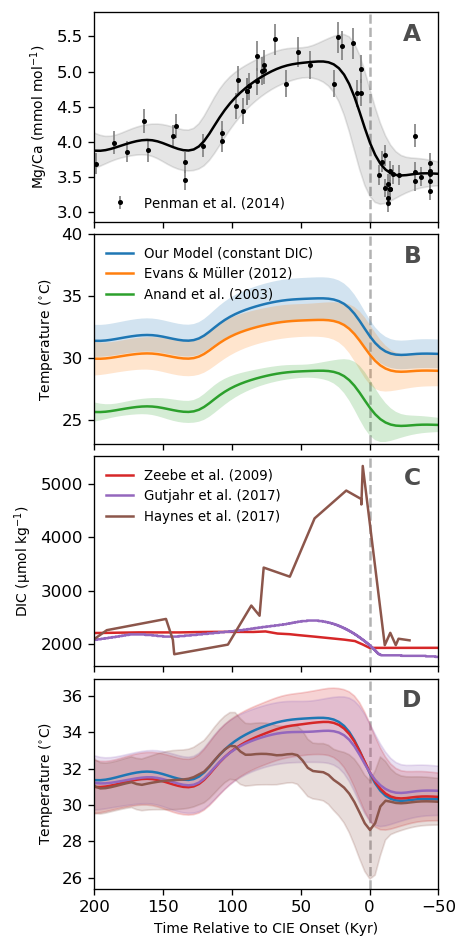

In [84]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[4,8])

# remove uncertainties from Mg/Casw and [Ca]sw, as they are plausibly constant across the excursion
u_petm_Ca = petm_Ca
petm_Ca = nom(u_petm_Ca)
u_petm_MgCa = petm_MgCa
petm_MgCa = nom(u_petm_MgCa)


dax, tax, cax, tax2 = axs

# Plot raw data
dax.errorbar(petm.loc[:, 'Time rel. PETM onset'], petm.loc[:, 'Mg/Ca_mmol'], petm.loc[:, 'Mg/Ca_mmol_std'],
             lw=0, elinewidth=1, color=(.5,.5,.5), mfc='k', mec='k', marker='o', markersize=2, label='Penman et al. (2014)')
dax.set_ylabel('Mg/Ca (mmol $mol^{-1}$)')

dax.plot(xnew, petm_mgca['mean'], c='k')
dax.fill_between(xnew, petm_mgca['mean'] - petm_mgca['std'], petm_mgca['mean'] + petm_mgca['std'], color='k', alpha=0.1, zorder=-2, label='_')

dax.legend(fontsize=8, framealpha=0)

# Plot Temperature conversion using different functions

# Our Model
petm_pred = T_fn_u((nom(petm_mgca_eprop), petm_MgCa, 2000 * 1e-6, petm_Ca * 1e-3), *aparams)
plot_pred(xnew, petm_pred, tax, label='Our Model (constant DIC)')

# Evans 2012
e2012_H = 0.41
e2012_A = un.ufloat(.09, .003)
e2012_B = un.ufloat(0.38, .02)
evans2012_pred = evans2012_temp(petm_mgca_eprop, petm_MgCa, e2012_A, e2012_B, e2012_H)
plot_pred(xnew, evans2012_pred, tax, label='Evans & Müller (2012)')

# Anand
anand_pred = exponent_temp(petm_mgca_eprop, *exp_anand_params)
plot_pred(xnew, anand_pred, tax, label='Anand et al. (2003)')


tax.set_ylim(23, 40)
tax.set_ylabel('Temperature ($^{\circ}C$)')
tax.legend(loc='upper left', fontsize=8, framealpha=0)

# DIC Records
cax.plot(petm_DIC_LOSCAR.Time_WRT_CIE, petm_DIC_LOSCAR.DIC * 1e6, label='Zeebe et al. (2009)', c='C3')
cax.plot(petm_DIC_Gutjahr.Time_WRT_CIE, petm_DIC_Gutjahr.DIC * 1e6, label='Gutjahr et al. (2017)', c='C4')
cax.plot(petm_DIC_Haynes.Time_WRT_CIE, petm_DIC_Haynes.DIC * 1e6, label='Haynes et al. (2017)', c='C5')

cax.set_ylabel('DIC ($\mu mol\ kg^{-1}$)')
cax.legend(fontsize=8, framealpha=0)

# DIC Correction
# uncorrected
plot_pred(xnew, petm_pred, tax2, label='2000', ebar=False)

# LOSCAR DIC
pred_LOSCAR = T_fn_u((petm_mgca_eprop, nom(petm_MgCa), interp_petm_DIC_LOSCAR, nom(petm_Ca) * 1e-3), *aparams)
plot_pred(xnew, pred_LOSCAR, tax2, label='Zeebe et al. (2009)', color='C3')

# Gutjahr DIC
pred_Gutjahr = T_fn_u((petm_mgca_eprop, nom(petm_MgCa), interp_petm_DIC_Gutjahr, nom(petm_Ca) * 1e-3), *aparams)
plot_pred(xnew, pred_Gutjahr, tax2, label='Gutjahr et al. (2017)', color='C4')

# Haynes DIC
pred_Haynes = T_fn_u((petm_mgca_eprop, nom(petm_MgCa), interp_petm_DIC_Haynes, nom(petm_Ca) * 1e-3), *aparams)
plot_pred(xnew, pred_Haynes, tax2, label='Haynes et al. (2017)', color='C5')

tax2.set_ylabel('Temperature ($^{\circ}C$)')

tax2.invert_xaxis()
tax2.set_xlim(200, -50)
tax2.set_xlabel('Time Relative to CIE Onset (Kyr)')

for ax, label in zip(axs, ['A', 'B', 'C', 'D']):
    ax.axvline(0, color=(0,0,0,0.3), ls='dashed', zorder=-2)
    ax.text(.95, .95, label, ha='right', va='top', transform=ax.transAxes, weight='bold',
         fontsize=14, color=(.3, .3, .3), zorder=2)

fig.tight_layout(h_pad=0.02)

# fig.savefig('Plots/11_PETM.pdf')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 8.2.1 Calculate T excursions in different scenarios

In [85]:
def excursion_calc(x, y):
    pre = np.mean(y[x < -30])
    post = np.max(y)
    max_time = x[nom(y) == nom(post)][0]
    return pre, post, post - pre, max_time

In [86]:
exc = {'Our_Model_NoDIC': excursion_calc(xnew, petm_pred),
       'Anand': excursion_calc(xnew, anand_pred),
       'Evans2012': excursion_calc(xnew, evans2012_pred),
       'Our_Model_LOSCAR': excursion_calc(xnew, pred_LOSCAR),
       'Our_Model_Gutjahr': excursion_calc(xnew, pred_Gutjahr),
       'Our_Model_Haynes': excursion_calc(xnew, pred_Haynes),}

excursions = pd.DataFrame(exc).T
excursions.columns = ['pre', 'post', 'excursion', 'excursion_time']

Haynes_min = excursion_calc(xnew, -pred_Haynes)
Haynes_min = -Haynes_min[0], -Haynes_min[1], -Haynes_min[2], Haynes_min[3]
excursions.loc['Our_Model_Haynes_Minimum'] = Haynes_min

excursions

,pre,post,excursion,excursion_time
Our_Model_NoDIC,30.3+/-1.2,34.8+/-1.7,4.5+/-0.6,37.4242
Anand,24.57+/-0.27,29.0+/-0.6,4.4+/-0.7,37.4242
Evans2012,28.9+/-1.2,33.1+/-1.4,4.1+/-0.6,37.4242
Our_Model_LOSCAR,30.5+/-1.2,34.6+/-1.8,4.1+/-0.9,33.6566
Our_Model_Gutjahr,30.8+/-1.3,34.1+/-1.8,3.3+/-1.0,29.8889
Our_Model_Haynes,30.2+/-1.2,33.3+/-1.8,3.1+/-1.2,101.475
Our_Model_Haynes_Minimum,30.2+/-1.2,28.6+/-2.7,-1.6+/-2.6,-0.252525


<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

### 8.3 Estimate DIC from Mg/Ca and $\delta^{18}O$ <a id='DIC_d18O'></a>

#### 8.3.1 Combine Penman Mg/Ca with Zachos d18O

In [87]:
# d18O data from Zachos et al (2003)
zdf = pd.read_csv('Data/Zachos_2003_d18OT.csv')
# Mg/Ca data from Zachos et al (2003)
zmg = pd.read_csv('Data/Zachos_2003_MgCa.csv')

Text(0, 0.5, 'Mg/Ca')

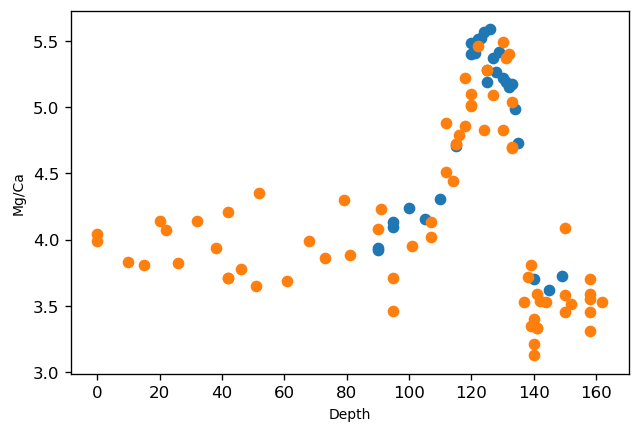

In [88]:
# compare and align Zachos and Penman Records eyball-o-metrically (M.J. Ellwood, pers. comm.)
offset = 90  # start of Zachos record in Penman's Depth scale
plt.scatter((zmg.Compositedepth_mcd - zmg.Compositedepth_mcd.min()) * 100 + offset, zmg.MgCa_mmolmol)
plt.scatter(petm.loc[:, 'Depth_cm'], petm.loc[:, 'Mg/Ca_mmol'])
plt.xlabel('Depth')
plt.ylabel('Mg/Ca')

In [89]:
# interpolate Penman's ages onto Zachos' data
zmg.loc[:, 'Depth_cm_Penman'] = (zmg.Compositedepth_mcd - zmg.Compositedepth_mcd.min()) * 100 + offset
zdf.loc[:, 'Depth_cm_Penman'] = (zdf.Compositedepth_mcd - zdf.Compositedepth_mcd.min()) * 100 + offset

zmg.loc[:, 'Age_ma'] = np.interp(zmg.loc[:, 'Depth_cm_Penman'], petm.loc[:, 'Depth_cm'], petm.loc[:, 'Age_ma'])
zdf.loc[:, 'Age_ma'] = np.interp(zdf.loc[:, 'Depth_cm_Penman'], petm.loc[:, 'Depth_cm'], petm.loc[:, 'Age_ma'])

zmg.loc[:, 'Time rel. PETM onset'] = 1e3 * (56 - zmg.loc[:, 'Age_ma'])
zdf.loc[:, 'Time rel. PETM onset'] = 1e3 * (56 - zdf.loc[:, 'Age_ma'])

Text(0, 0.5, 'Mg/Ca')

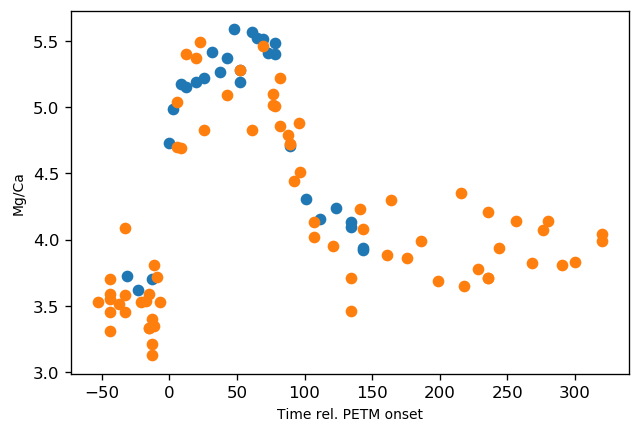

In [90]:
plt.scatter(zmg.loc[:, 'Time rel. PETM onset'], zmg.MgCa_mmolmol)
plt.scatter(petm.loc[:, 'Time rel. PETM onset'], petm.loc[:, 'Mg/Ca_mmol'])

plt.xlabel('Time rel. PETM onset')
plt.ylabel('Mg/Ca')

<div style="text-align: right"> <a href="#pagetop">Back to top</a></div>

#### 8.3.2 Calculate moving average d18O-derived temperature across the PETM

Text(0, 0.5, '$\\delta^{18}O$-derived Temperature')

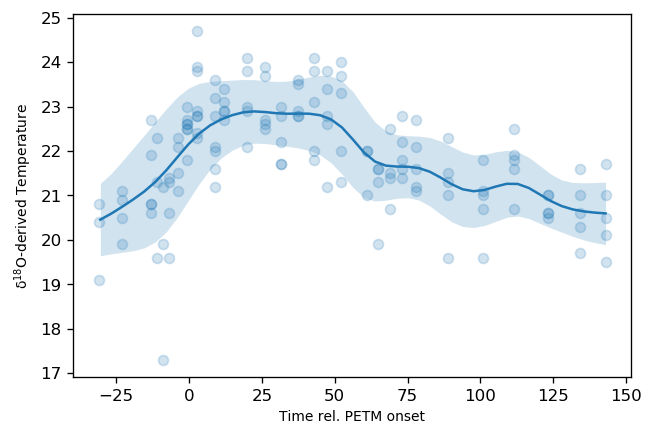

In [91]:
zx = zdf.loc[:, 'Time rel. PETM onset']
zy = zdf.Temp

time_ind = (xnew >= zx.min()) & (xnew <= zx.max())

zxnew = xnew[time_ind]
temp18O = weighted_moving_average(zx, zy, zxnew, fwhm=20)

plt.scatter(zx, zy, alpha=0.2)
plt.plot(zxnew, temp18O['mean'])
plt.fill_between(zxnew, temp18O['mean'] - temp18O['std'], temp18O['mean'] + temp18O['std'], alpha=0.2, color='C0', lw=0)

plt.xlabel('Time rel. PETM onset')
plt.ylabel('$\delta^{18}O$-derived Temperature')

The absolute temperatures here are too low, as discussed in Zachos et al (2003). We will therefore use the $\Delta T$ in this record, and apply it to the pre-PETM average Mg/Ca-calculated temperature, to estimate a temperature excursion across the PETM 

In [92]:
temp18O['delta'] = temp18O['mean'] - temp18O['mean'][0]

delta_temp = un.unumpy.uarray(temp18O['delta'], temp18O['std'])

In [93]:
# combine penman and zachos Mg/Ca data, and calculate moving weighted average across the PETM

ozmgx = zmg.loc[:, 'Time rel. PETM onset']
ozmgy = zmg.MgCa_mmolmol

pzmgx = petm.loc[:, 'Time rel. PETM onset']
pzmgy = petm.loc[:, 'Mg/Ca_mmol']

zmgx = np.concatenate([ozmgx, pzmgx])
zmgy = np.concatenate([ozmgy, pzmgy])

zMgCa = weighted_moving_average(zmgx, zmgy, zxnew, fwhm=20)
uzMgCa = un.unumpy.uarray(zMgCa['mean'], zMgCa['std'])


In [94]:
# calculate DIC from Mg/Ca and temperature

z_petm_MgCa = nom(petm_MgCa[time_ind])
z_petm_Ca = nom(petm_Ca[time_ind]) * 1e-3
z_pre_petm_DIC = 2000e-6

pre_petm_MgCa = un.ufloat(zmgy[zmgx < -15].mean(), zmgy[zmgx < -15].std())

# 1. calculate pre-PETM temperature
pre_PETM = (pre_petm_MgCa, z_petm_MgCa[0], z_pre_petm_DIC, z_petm_Ca[0])  # note assuming 2000 DIC pre-petm
pre_temp = T_fn_u(pre_PETM, *aparams)

# 2. apply deltaT from 18O across PETM
petm_18O_temp = pre_temp + delta_temp

# 3. calculate DIC
petm_DIC = DIC_fn_u((z_petm_MgCa, z_petm_Ca, uzMgCa, petm_18O_temp), *aparams) * 1e6

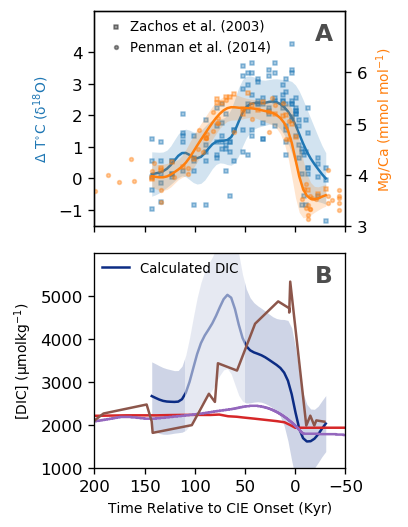

In [95]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=[3.5, 4.5], sharex=True)

labels = 'ABCDE'

ax1.scatter(zx, zy.values - temp18O['mean'][0], s=5, alpha=0.4, c='C0', marker='s')
ax1.plot(zxnew, temp18O['delta'], c='C0')
ax1.fill_between(zxnew, 
                 temp18O['delta'] - temp18O['std'], 
                 temp18O['delta'] + temp18O['std'], alpha=0.2, color='C0', lw=0)

ax1a = ax1.twinx()
ax1a.scatter(ozmgx, ozmgy, s=5, alpha=0.4, c='C1', marker='s')
ax1a.scatter(pzmgx, pzmgy, s=5, alpha=0.4, c='C1')
ax1a.plot(zxnew, zMgCa['mean'], c='C1')
ax1a.fill_between(zxnew, 
                  zMgCa['mean'] - zMgCa['std'], 
                  zMgCa['mean'] + zMgCa['std'], alpha=0.2, color='C1', lw=0)

ax1.set_ylim(-1.5, 5.3)
ax1.set_yticks([-1, 0, 1, 2, 3, 4])
ax1.set_ylabel('$\Delta\ T^{\circ}C\ (\delta^{18}O)$', color='C0')
ax1a.set_ylim(3, 7.2)
ax1a.set_yticks([3, 4, 5, 6])
ax1a.set_ylabel('Mg/Ca (mmol $mol^{-1}$)', color='C1')

ax2.plot(zxnew, nom(petm_DIC), c='#0c2c84', zorder=-3)
ax2.fill_between(zxnew, 
                 nom(petm_DIC) - err(petm_DIC), 
                 nom(petm_DIC) + err(petm_DIC),
                 alpha=0.2, color='#0c2c84', lw=0, zorder=-4)
ax2.plot(petm_DIC_LOSCAR.Time_WRT_CIE, petm_DIC_LOSCAR.DIC * 1e6, label='_Zeebe et al. (2009)', c='C3')
ax2.plot(petm_DIC_Gutjahr.Time_WRT_CIE, petm_DIC_Gutjahr.DIC * 1e6, label='_Gutjahr et al. (2017)', c='C4')
ax2.plot(petm_DIC_Haynes.Time_WRT_CIE, petm_DIC_Haynes.DIC * 1e6, label='_Haynes et al. (2017)', c='C5')

ax2.set_ylim(1000, 6000)
ax2.set_ylabel('[DIC] ($\mu mol kg^{-1}$)')
ax2.set_yticks([1000, 2000, 3000, 4000, 5000])
ax2.set_xlim(200, -50)

ax2.set_xlabel('Time Relative to CIE Onset (Kyr)')

ax1.scatter([], [], marker='s', s=5, label='Zachos et al. (2003)', c='k', alpha=0.4)
ax1.scatter([], [], s=5, label='Penman et al. (2014)', c='k', alpha=0.4)
ax1.legend(loc='upper left', fontsize=8, handletextpad=0.1,  framealpha=0, borderpad=0.1)

ax2.plot([], [], label='Calculated DIC', c='#0c2c84')
ax2.legend(loc='upper left', fontsize=8,  framealpha=0, borderpad=0.1)

for i, ax in enumerate([ax1, ax2]):
    ax.text(.95, .95, labels[i], ha='right', va='top', transform=ax.transAxes, weight='bold',
            fontsize=14, color=(.3, .3, .3), zorder=2)

ax2.axvspan(110, 50, color=(1,1,1,0.5), zorder=-2, lw=0)

fig.tight_layout()

# fig.savefig('Plots/12_PETM_DIC.pdf')

In [96]:
# first excursion
petm_DIC[(zxnew > 10) & (zxnew < 30)].mean() - un.nominal_value(petm_DIC[0])

1382.9412843467976+/-757.8944807357126

In [97]:
# second excursion
petm_DIC[(zxnew > 60) & (zxnew < 120)].max() - petm_DIC[(zxnew > 10) & (zxnew < 30)].mean()

1613.031153177597+/-1446.7325012841877